# Imports

In [1]:
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from abacusnbody.data.read_abacus import read_asdf
import h5py
import os

import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf

from scipy.spatial import KDTree, cKDTree
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata, UnivariateSpline, interp1d
from scipy.integrate import quad

from collections import Counter
from pycorr import TwoPointCorrelationFunction, TwoPointCounter

import psutil
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import gc
import pickle

import importlib
import functions
importlib.reload(functions)
from functions import *
from astropy.io import fits

## Halos

In [2]:
compaso_dir = '/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100'

str_z = 'z0.500'
cols = ['id', 'x_L2com', 'v_L2com', 'N']

path_to_sim = os.path.join(compaso_dir, "halos", str_z)
hcat = CompaSOHaloCatalog(path_to_sim, fields=cols, cleaned=True)

## Masses

In [3]:
## CompaSo

Mhalos_CS =  hcat.header['ParticleMassHMsun']*hcat.halos['N']

mask = Mhalos_CS > 0
hcat_pos = hcat.halos[mask]
Mhalos_CS = Mhalos_CS[mask]

boxsize_cs = hcat.header['BoxSize']
print("Box size CompaSo:", boxsize_cs)

Box size CompaSo: 1000.0


In [4]:
## Rockstar

data = np.load('/pscratch/sd/g/guittonm/rockstar_parent_halos.npz')

Mhalos_RS = data['masses']
ids_RS = data['ids']
num_particles_RS = data['num_particles']
positions_RS = data['positions']
velocities_RS = data['velocities']

file_path_rs = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/rockstar.cfg"
boxsize_rs = get_variable(file_path_rs, name='BOX_SIZE')
print(f"Box size Rockstar: {boxsize_rs}")

Box size Rockstar: 1000


In [5]:
print(len(Mhalos_RS))
print(len(Mhalos_CS))

93318302
48359672


## Particles

In [6]:
## CompaSo

# Paths to particle files
field_particle_dirs = [os.path.join(compaso_dir, "halos", str_z, "field_rv_A"),
                       os.path.join(compaso_dir, "halos", str_z, "field_rv_B")]

field_particle_files = [os.path.join(d, f) for d in field_particle_dirs for f in os.listdir(d) if f.endswith(".asdf")]

print(f"Total files to process: {len(field_particle_files)}")

batch_size = 2

file_path = "/pscratch/sd/g/guittonm/all_positions.npy"

# Same positions for both simulations
positions_mm = np.load(file_path, mmap_mode='r')  # mmap_mode for huge data
print(f"Total positions : {positions_mm.shape[0]}")

Total files to process: 32
Total positions : 2538452676


# Mass study

In [7]:
colors_list = ['green', 'red'] 
colors_ratio=['blue']
labels_name = ['CompaSO', 'Rockstar']
labels_scale = ['Linear', 'Log']
labels_ratio = ['Rockstar / Compaso']

## Bins

In [18]:
# Linear bins
bins = np.histogram_bin_edges(np.concatenate([Mhalos_RS, Mhalos_CS]), bins=50)

# Logarithmic bins
min_mass = max(Mhalos_RS.min(), Mhalos_CS.min())
max_mass = max(Mhalos_RS.max(), Mhalos_CS.max())

bins_log = np.logspace(np.log10(min_mass), np.log10(max_mass), num=30)
bins_log_centers = 0.5 * (bins_log[:-1] + bins_log[1:])

print(f"Minimum log bins : {bins_log[0]:.2e}")
print(f"Maximum log bins : {bins_log[29]:.2e}")

Minimum log bins : 7.38e+10
Maximum log bins : 1.23e+15


In [19]:
mask_CS = (Mhalos_CS > bins_log[0]) & (Mhalos_CS < bins_log[-1])
mask_RS = (Mhalos_RS > bins_log[0]) & (Mhalos_RS < bins_log[-1])

print("Halos CS in bins:", np.sum(mask_CS))
print("Halos RS in bins:", np.sum(mask_RS))
print("Ratio inside bins:", np.sum(mask_RS) / np.sum(mask_CS))

Halos CS in bins: 47187717
Halos RS in bins: 46056229
Ratio inside bins: 0.9760215566266959


## HMF

In [20]:
hmf_rs_log, bin_centers_rs_log = compute_hmf(Mhalos_RS, bins_log)
hmf_cs_log, bin_centers_cs_log = compute_hmf(Mhalos_CS, bins_log)

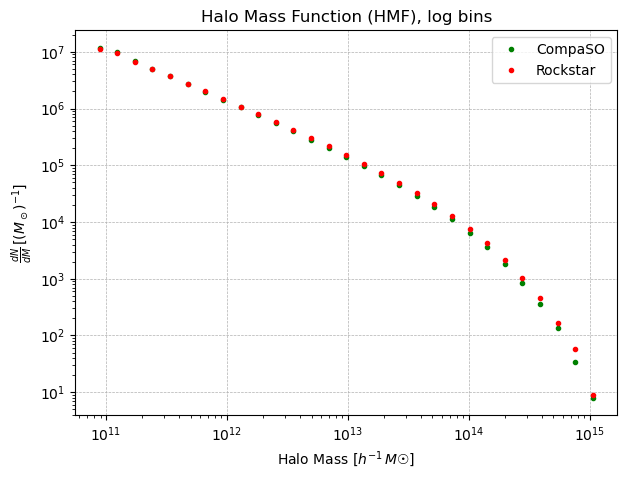

In [21]:
data_hmf = [hmf_cs_log, hmf_rs_log]
bins_hmf = [bin_centers_cs_log, bin_centers_rs_log]

plot_masses_fct(data_hmf, bins_hmf, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

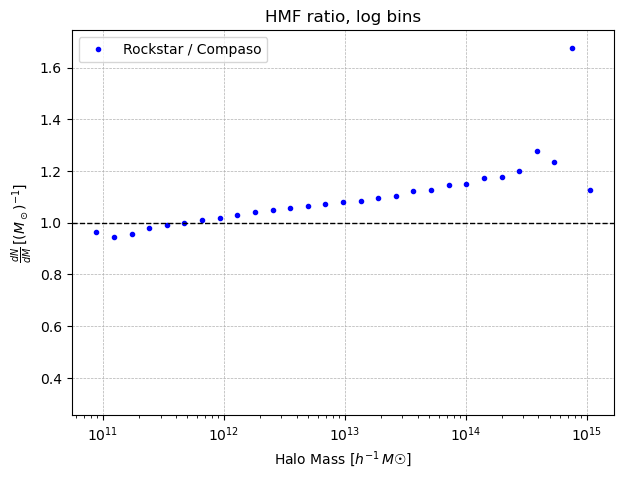

In [22]:
plot_masses_fct([hmf_rs_log / hmf_cs_log], 
                [bin_centers_rs_log], colors_list=colors_ratio, 
                labels_list=labels_ratio, linestyles_list=['none'], 
                scale='semilogx', title='HMF ratio, log bins', 
                ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$',
                center_around_one=True, margin_factor=0.1)

In [15]:
print(len(Mhalos_RS) / len(Mhalos_CS))

print(np.sum(hmf_rs_log) / np.sum(hmf_cs_log)) 

1.9296719382215826
0.9760215566266959


# Correlation function

## Halos positions

In [16]:
## CompaSo
  
positions_cs = np.array(hcat_pos['x_L2com'])
positions_cs = positions_cs.astype(np.float64)

print("Shape of positions CS:", positions_cs.shape) 
x_cs, y_cs, z_cs = positions_cs[:, 0], positions_cs[:, 1], positions_cs[:, 2]

x_cs = x_cs + boxsize_cs / 2
y_cs = y_cs + boxsize_cs / 2
z_cs = z_cs + boxsize_cs / 2

epsilon = 1e-5
z_cs[z_cs == 0] += epsilon

## Rockstar

print("Shape of positions RS:", positions_RS.shape)
x_rs, y_rs, z_rs = positions_RS[:, 0], positions_RS[:, 1], positions_RS[:, 2]

Shape of positions CS: (48359672, 3)
Shape of positions RS: (93318302, 3)


## SMU

### Minimum distances

In [17]:
# positions_cs = np.vstack((x_cs, y_cs, z_cs)).T  # Transformer en tableau (N, 3)
# tree_cs = cKDTree(positions_cs)

# positions_rs = np.vstack((x_rs, y_rs, z_rs)).T  # Transformer en tableau (N, 3)
# tree_rs = cKDTree(positions_rs)

# # Trouver la distance minimale entre chaque halo et son plus proche voisin
# distances, _ = tree_cs.query(positions_cs, k=2)  # `k=2` car le 1er voisin est lui-même
# min_distance_cs = np.min(distances[:, 1])  # On prend la distance au 2ème point

# distances_rs, _ = tree_cs.query(positions_rs, k=2)  # `k=2` car le 1er voisin est lui-même
# min_distance_rs = np.min(distances_rs[:, 1])  # On prend la distance au 2ème point

# print(f"Distance minimale entre halos dans CompaSO: {min_distance_cs:.5f} Mpc/h")
# print(f"Distance minimale entre halos dans Rockstar: {min_distance_rs:.5f} Mpc/h")

In [18]:
# np.savez('/pscratch/sd/g/guittonm/min_dist_pid_tot.npz', 
#          min_distance_cs=min_distance_cs,
#          min_distance_rs=min_distance_rs,
#          distances_rs=distances_rs,
#          distances_cs=distances)

data_min_dist_pid = np.load('/pscratch/sd/g/guittonm/min_dist_pid_tot.npz')

min_distance_cs = data_min_dist_pid['min_distance_cs']
min_distance_rs = data_min_dist_pid['min_distance_rs']
distances_cs = data_min_dist_pid['distances_cs']
distances_rs = data_min_dist_pid['distances_rs']

In [19]:
print('CompaSO', min_distance_cs)
print('Rockstar', min_distance_rs)

CompaSO 0.07136012807130881
Rockstar 0.10436790558775134


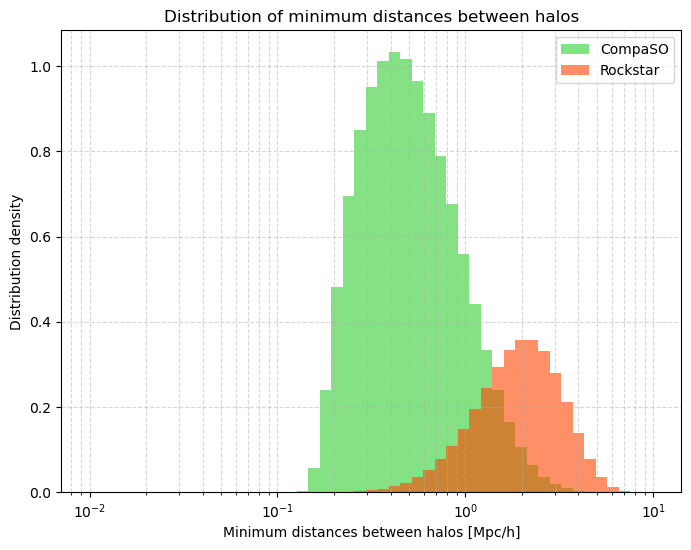

In [20]:
plt.figure(figsize=(8,6))
plt.hist(distances_cs[:, 1], bins=np.logspace(np.log10(0.01), np.log10(10), 50), alpha=0.6, label="CompaSO", density=True, color='limegreen')
plt.hist(distances_rs[:, 1], bins=np.logspace(np.log10(0.01), np.log10(10), 50), alpha=0.6, label="Rockstar", density=True, color='orangered')

plt.xscale("log")
plt.xlabel("Minimum distances between halos [Mpc/h]")
plt.ylabel("Distribution density")
plt.title("Distribution of minimum distances between halos")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

### Bins

In [21]:
bins_s = np.linspace(0, 100, 51)  # Distance intervals in Mpc/h
bins_mu = np.linspace(-1, 1, 201)    # Angle cosine intervals

bins_log_s = np.logspace(np.log10(0.01), np.log10(100), 30)

In [22]:
ells = (0, 2, 4)
wedges = (-1., -2./3, -1./3, 0., 1./3, 2./3, 1.)

### 2PCF linear

In [23]:
# ## CompaSO

# results_smu_cs = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_cs, y_cs, z_cs),  # Halo positions
#     boxsize=boxsize_cs,  
#     los='z',
#     nthreads=55
# )

# # Results
# xi_cs = results_smu_cs.corr  # Values of 2PCF
# rp_cs = results_smu_cs.sep  # Corresponding distances

# print('Shape of s :', rp_cs.shape)  # Should be dimension (n,)
# print(f'Shape of xi(s) : {xi_cs.shape}')

In [24]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs_tot.npz', 
#          results_smu_cs=results_smu_cs,
#          rp_cs=rp_cs, 
#          xi_cs=xi_cs)

data_smu_cs = np.load('/pscratch/sd/g/guittonm/smu_cs_tot.npz', allow_pickle=True)

results_smu_cs = data_smu_cs['results_smu_cs'].item()
rp_cs = data_smu_cs['rp_cs']
xi_cs = data_smu_cs['xi_cs']

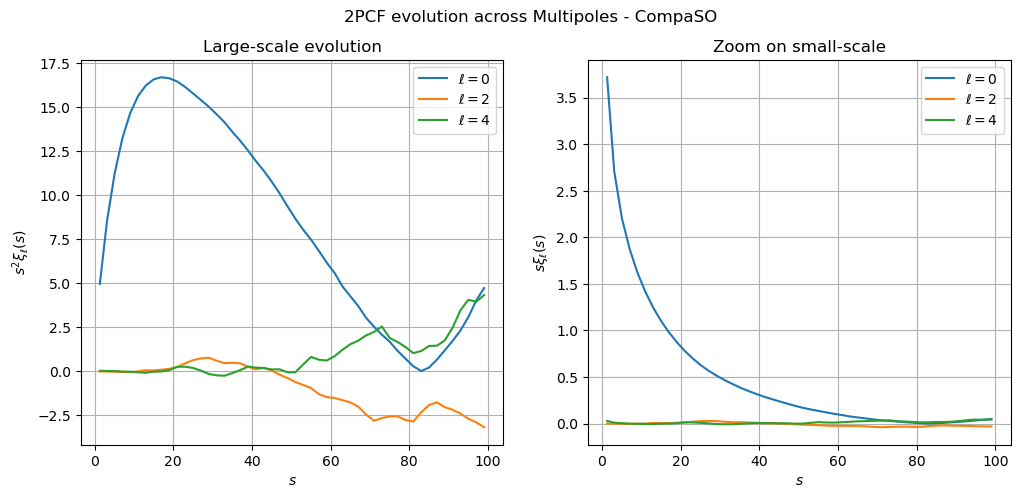

In [25]:
print_multipoles(results_smu_cs, ells, title = 'CompaSO')

In [26]:
# ## Rockstar

# results_smu_rs = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Distance markers for bins 
#     data_positions1=(x_rs, y_rs, z_rs),  # Halo positions
#     boxsize=boxsize_rs,   
#     los='z',
#     nthreads=26
# )   
 
# # Results 
# xi_rs = results_smu_rs.corr  # Values of 2PCF  
# rp_rs = results_smu_rs.sep  # Corresponding distances

# print('Shape of s :', rp_rs.shape)  # Should be dimension (n,)
# print(f'Shape of xi(s) : {xi_rs.shape}')

In [27]:
# np.savez('/pscratch/sd/g/guittonm/smu_rs_pid_tot.npz', 
#          results_smu_rs=results_smu_rs,
#          rp_rs=rp_rs,  
#          xi_rs=xi_rs) 

data_smu_rs = np.load('/pscratch/sd/g/guittonm/smu_rs_pid_tot.npz', allow_pickle=True)
 
results_smu_rs = data_smu_rs['results_smu_rs'].item()
rp_rs = data_smu_rs['rp_rs'] 
xi_rs = data_smu_rs['xi_rs']

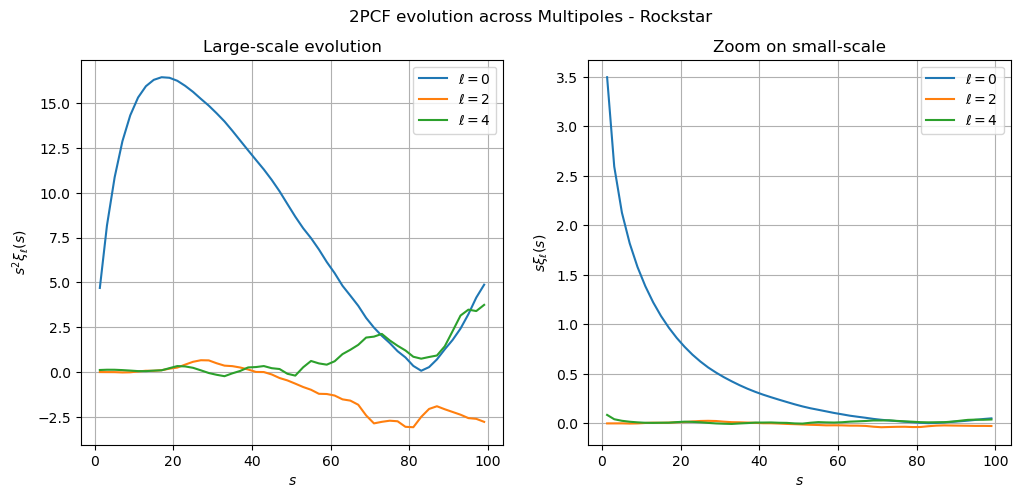

In [28]:
print_multipoles(results_smu_rs, ells, title = 'Rockstar')

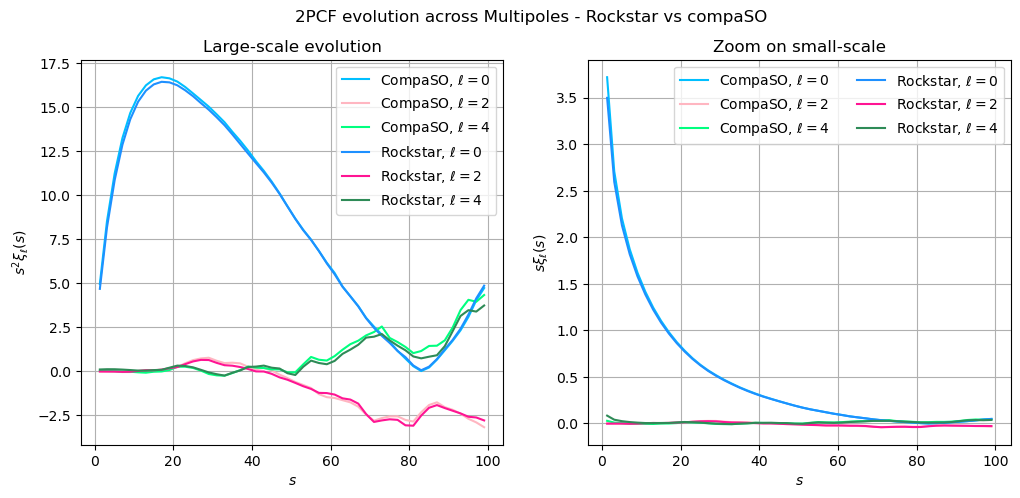

In [29]:
results_smu_list = [results_smu_cs, results_smu_rs]
colors_smu = ['deepskyblue', 'lightpink', 'springgreen', 'dodgerblue', 'deeppink', 'seagreen']

print_many_multipoles(results_list=results_smu_list, labels=['CompaSO', 'Rockstar'], colors_list=colors_smu, ells=ells, title='Rockstar vs compaSO')

### 2PCF log

In [30]:
# ## CompaSO

# results_smu_cs_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_cs, y_cs, z_cs),  # Halo positions
#     boxsize=boxsize_cs,  
#     los='z',
#     nthreads=55
# )

# # Results
# xi_cs_log = results_smu_cs_log.corr  # Values of 2PCF
# rp_cs_log = results_smu_cs_log.sep  # Corresponding distances

In [31]:
# np.savez('/pscratch/sd/g/guittonm/smu_log_cs_tot.npz', 
#          results_smu_cs_log=results_smu_cs_log,
#          rp_cs_log=rp_cs_log, 
#          xi_cs_log=xi_cs_log)

data_smu_cs_log = np.load('/pscratch/sd/g/guittonm/smu_log_cs_tot.npz', allow_pickle=True)

results_smu_cs_log = data_smu_cs_log['results_smu_cs_log'].item()
rp_cs_log = data_smu_cs_log['rp_cs_log']
xi_cs_log = data_smu_cs_log['xi_cs_log']

In [32]:
nan_mask = np.isnan(results_smu_cs_log.sep)

print(f"Nombre total de NaN dans `sep`: {np.sum(nan_mask)}")

if np.sum(nan_mask) > 0:
    print("Indices où `sep` contient des NaN (log_s, mu):")
    nan_indices = np.argwhere(nan_mask)
    print(nan_indices[:20])  # Afficher les 20 premiers indices NaN pour voir la tendance

    print("Corresponding log_s values for NaN:")
    print(bins_log_s[nan_indices[:, 0]])

    print("Corresponding mu values for NaN:")
    print(bins_mu[nan_indices[:, 1]])

Nombre total de NaN dans `sep`: 1496
Indices où `sep` contient des NaN (log_s, mu):
[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]]
Corresponding log_s values for NaN:
[0.01       0.01       0.01       ... 0.09236709 0.09236709 0.09236709]
Corresponding mu values for NaN:
[-1.   -0.99 -0.98 ...  0.96  0.97  0.98]


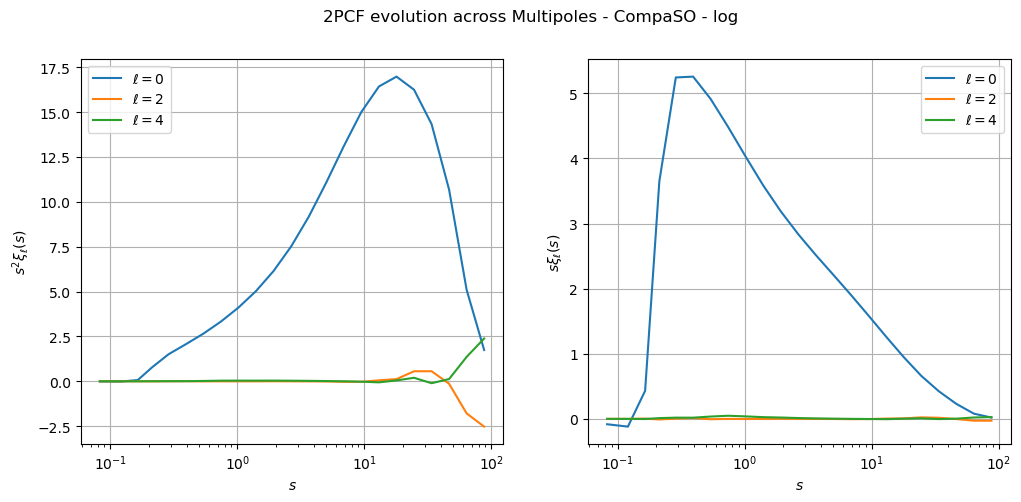

In [33]:
print_multipoles_log(results_smu_cs_log, ells, title = 'CompaSO - log')

In [34]:
# ## Rockstar

# results_smu_rs_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_rs, y_rs, z_rs),  # Halo positions
#     boxsize=boxsize_rs,  
#     los='z', 
#     nthreads=55
# )    

# # Results 
# xi_rs_log = results_smu_rs_log.corr  # Values of 2PCF 
# rp_rs_log = results_smu_rs_log.sep  # Corresponding distances

In [35]:
# np.savez('/pscratch/sd/g/guittonm/smu_log_rs_pid_tot.npz', 
#          results_smu_rs_log=results_smu_rs_log,
#          rp_rs_log=rp_rs_log, 
#          xi_rs_log=xi_rs_log)

data_smu_rs_log = np.load('/pscratch/sd/g/guittonm/smu_log_rs_pid_tot.npz', allow_pickle=True)

results_smu_rs_log = data_smu_rs_log['results_smu_rs_log'].item()
rp_rs_log = data_smu_rs_log['rp_rs_log']
xi_rs_log = data_smu_rs_log['xi_rs_log']

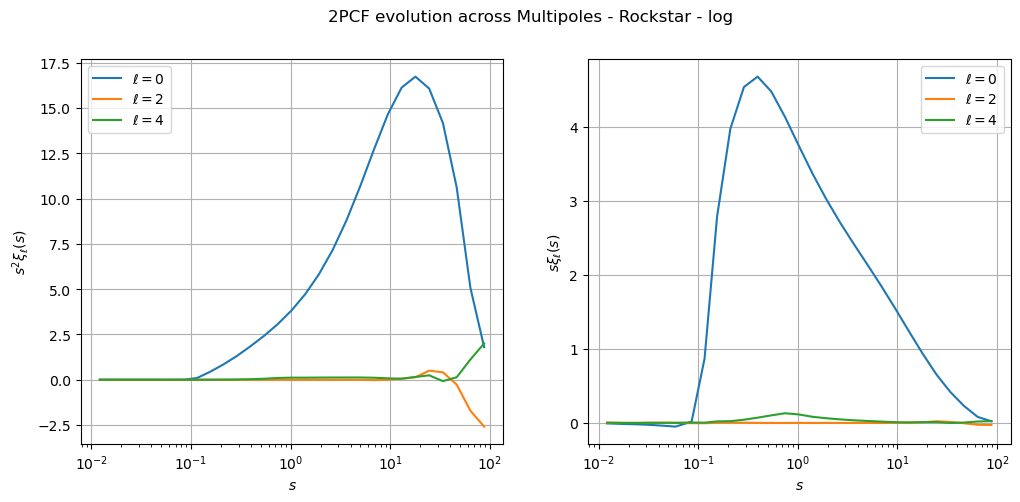

In [36]:
print_multipoles_log(results_smu_rs_log, ells, title = 'Rockstar - log')

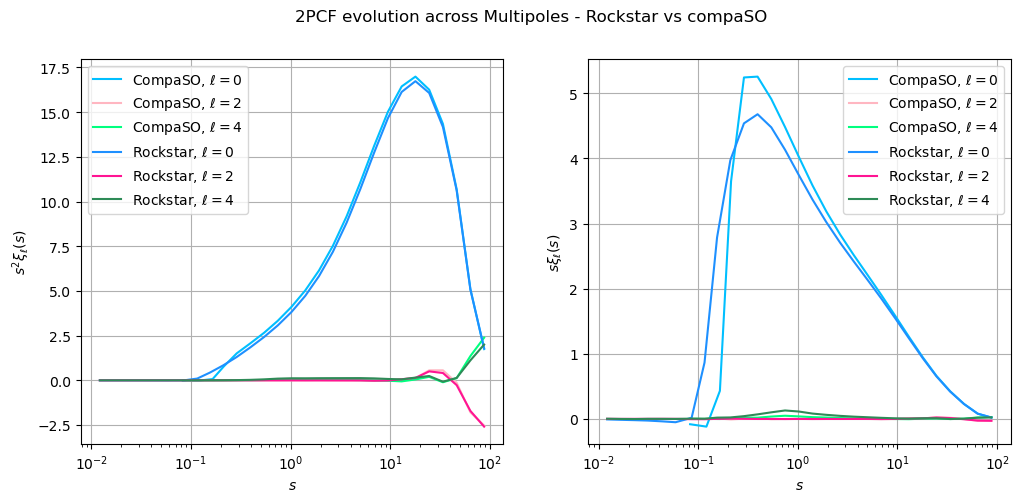

In [37]:
results_smu_log_list = [results_smu_cs_log, results_smu_rs_log]
colors_smu = ['deepskyblue', 'lightpink', 'springgreen', 'dodgerblue', 'deeppink', 'seagreen']

print_many_multipoles_log(results_list=results_smu_log_list, labels=['CompaSO', 'Rockstar'], colors_list=colors_smu, ells=ells, title='Rockstar vs compaSO')

Shape of pairs_s_cs: (29, 200)
Shape of pairs_s_rs: (29, 200)


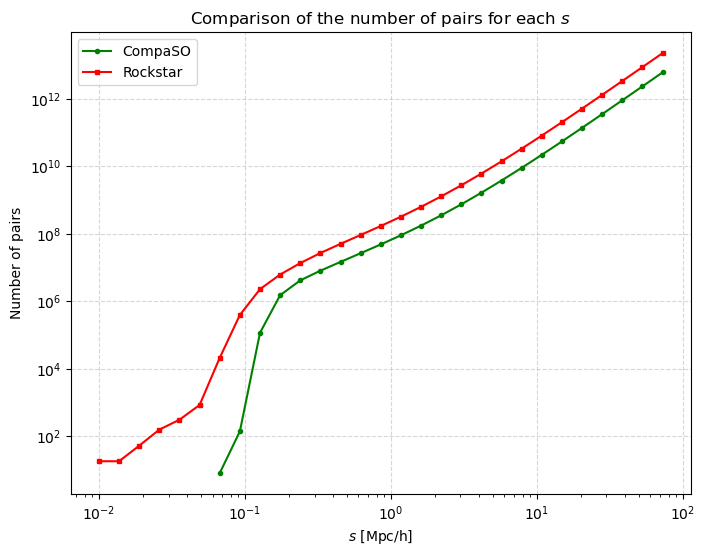

[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 8.00000e+00 1.38000e+02 1.15166e+05]


In [38]:
pairs_s_cs = results_smu_cs_log.D1D2.wcounts
pairs_s_rs = results_smu_rs_log.D1D2.wcounts    # Somme sur mu

# Vérification de la forme des données
print("Shape of pairs_s_cs:", pairs_s_cs.shape)
print("Shape of pairs_s_rs:", pairs_s_rs.shape)

# Somme sur mu pour obtenir le nombre de paires par bin de s
pairs_s_cs_summed = np.sum(pairs_s_cs, axis=-1)  
pairs_s_rs_summed = np.sum(pairs_s_rs, axis=-1)

# Création du masque : où la somme des paires n’est pas nulle
mask_nonzero = pairs_s_cs_summed > 0

# Appliquer le même masque sur les deux courbes (optionnel, tu peux aussi en faire un pour RS)
s_values_cs = bins_log_s[:-1][mask_nonzero]
pairs_values_cs = pairs_s_cs_summed[mask_nonzero]

# Tracé
plt.figure(figsize=(8,6))
plt.loglog(s_values_cs, pairs_values_cs, label="CompaSO", marker="o", markersize=3, linestyle="-", color='green')
plt.loglog(bins_log_s[:-1], pairs_s_rs_summed, label="Rockstar", marker="s", markersize=3, linestyle="-", color = 'red')

plt.xlabel(r"$s$ [Mpc/h]")
plt.ylabel("Number of pairs")
plt.title("Comparison of the number of pairs for each $s$")
plt.legend()
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

print(pairs_s_cs_summed[0:9])

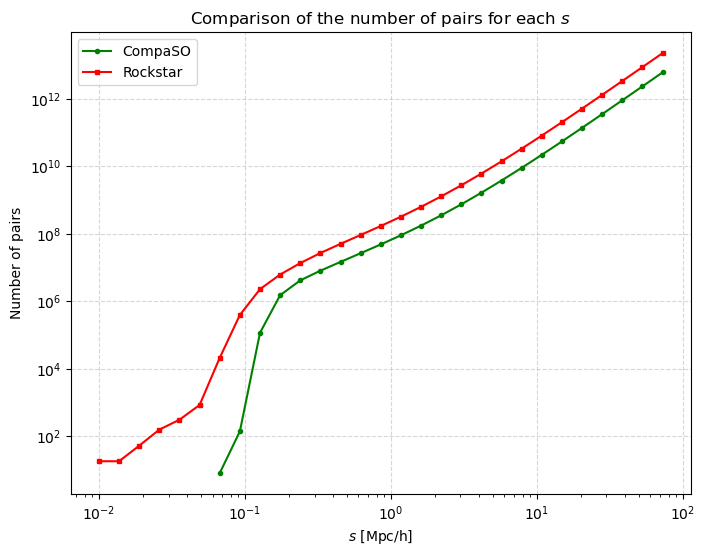

In [39]:
# Création du masque : où la somme des paires n’est pas nulle
mask_nonzero = pairs_s_cs_summed > 0

# Appliquer le même masque sur les deux courbes (optionnel, tu peux aussi en faire un pour RS)
s_values_cs = bins_log_s[:-1][mask_nonzero]
pairs_values_cs = pairs_s_cs_summed[mask_nonzero]
pairs_values_rs = pairs_s_rs_summed[mask_nonzero]  # ou garde tout si tu veux comparer tout

# Tracé
plt.figure(figsize=(8,6))
plt.loglog(s_values_cs, pairs_values_cs, label="CompaSO", marker="o", markersize=3, linestyle="-", color='green')
plt.loglog(bins_log_s[:-1], pairs_s_rs_summed, label="Rockstar", marker="s", markersize=3, linestyle="-", color = 'red')

plt.xlabel(r"$s$ [Mpc/h]")
plt.ylabel("Number of pairs")
plt.title("Comparison of the number of pairs for each $s$")
plt.legend()
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

## RPPI

### Bins

In [19]:
# bins_rp = np.linspace(0, 100, 101)  # (0,40,41)
bins_pi = np.linspace(-100, 100, 81)   # (-40,40,81)
bins_rp = np.logspace(np.log10(0.01), np.log10(100), 41) #np.log10(0.01)

### No RSD

In [20]:
# ## CompaSo

# results_rppi_cs = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_cs),  # Positions des halos
#     nthreads=55,
#     boxsize=boxsize_cs,
#     los='z'
# )

# pi_cs = results_rppi_cs.sepavg(axis=1)
# xi_rppi_cs = results_rppi_cs.corr

In [21]:
# np.savez('/pscratch/sd/g/guittonm/rppi_cs_tot.npz', 
#          results_rppi_cs=results_rppi_cs,
#          pi_cs=pi_cs, 
#          xi_rppi_cs=xi_rppi_cs)

data_rppi_cs = np.load('/pscratch/sd/g/guittonm/rppi_cs_tot.npz', allow_pickle=True)

results_rppi_cs = data_rppi_cs['results_rppi_cs'].item()
pi_cs = data_rppi_cs['pi_cs']
xi_rppi_cs = data_rppi_cs['xi_rppi_cs']

(40, 80)


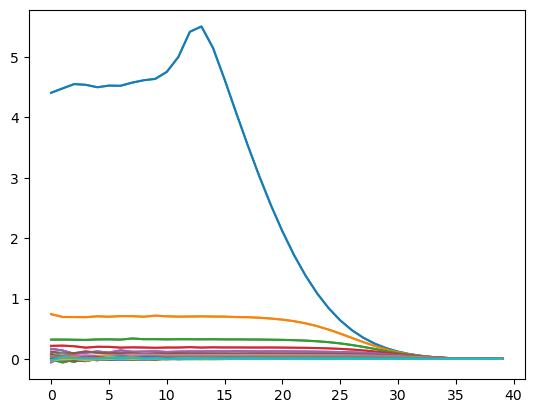

In [22]:
plt.plot(xi_rppi_cs)
print(xi_rppi_cs.shape)

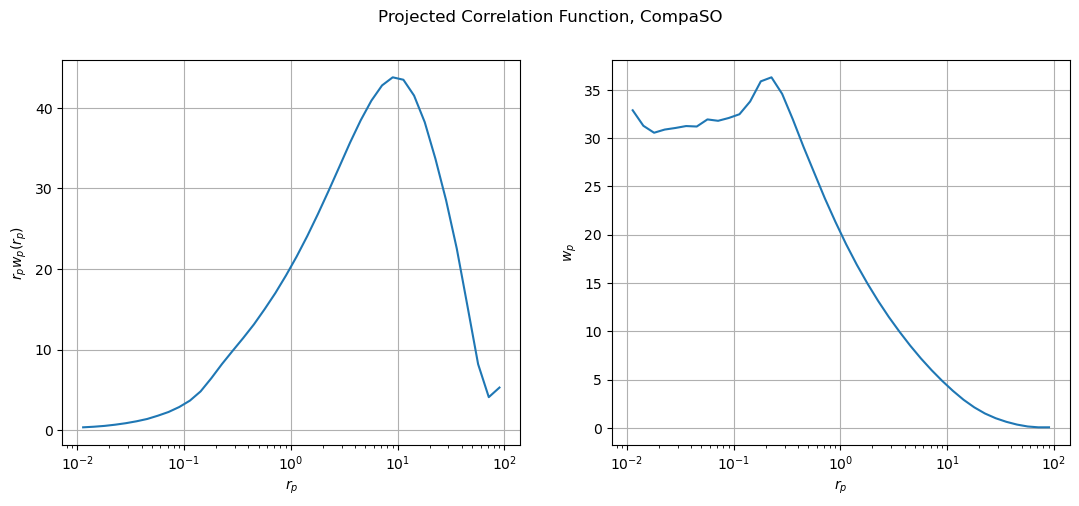

In [23]:
sep_cs = projected_pcf(results_rppi_cs, title='CompaSO')

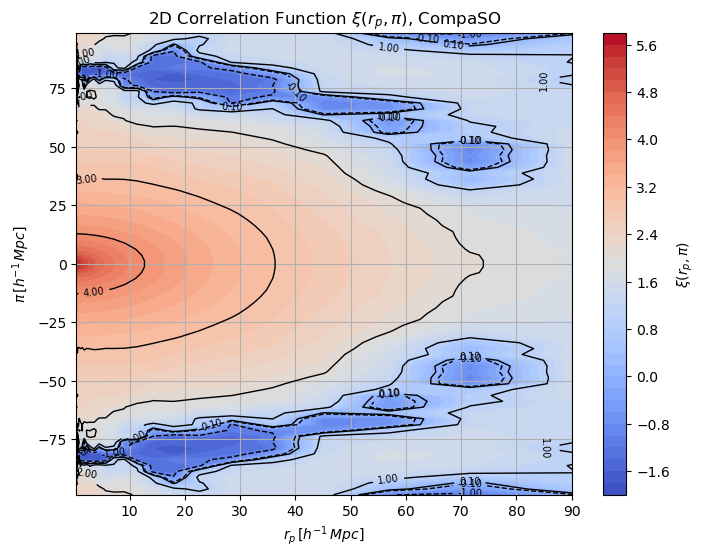

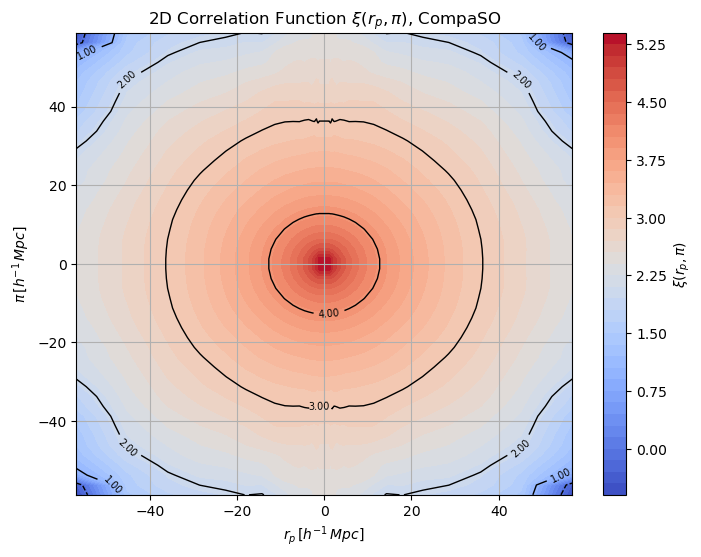

In [24]:
print_xi(results_rppi_cs, pi_lim=100, r_lim=0.3, title='CompaSO')

# print_xi_round_test_nolog(results_rppi_cs, pi_lim=50, r_lim=50, r_lim_min=0.5, title='CompaSO')

print_xi_round(results_rppi_cs, pi_lim=60, r_lim=60, r_lim_min=1, title='CompaSO')


In [25]:
# ## Rockstar
 
# results_rppi_rs = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rs),  # Positions des halos
#     nthreads=55,
#     boxsize=boxsize_cs, 
#     los='z'
# )

# pi_rs = results_rppi_rs.sepavg(axis=1)
# xi_rppi_rs = results_rppi_rs.corr

In [26]:
# np.savez('/pscratch/sd/g/guittonm/rppi_rs_pid_tot.npz', 
#          results_rppi_rs=results_rppi_rs,
#          pi_rs=pi_rs, 
#          xi_rppi_rs=xi_rppi_rs)

data_rppi_rs = np.load('/pscratch/sd/g/guittonm/rppi_rs_pid_tot.npz', allow_pickle=True)

results_rppi_rs = data_rppi_rs['results_rppi_rs'].item()
pi_rs = data_rppi_rs['pi_rs']
xi_rppi_rs = data_rppi_rs['xi_rppi_rs']

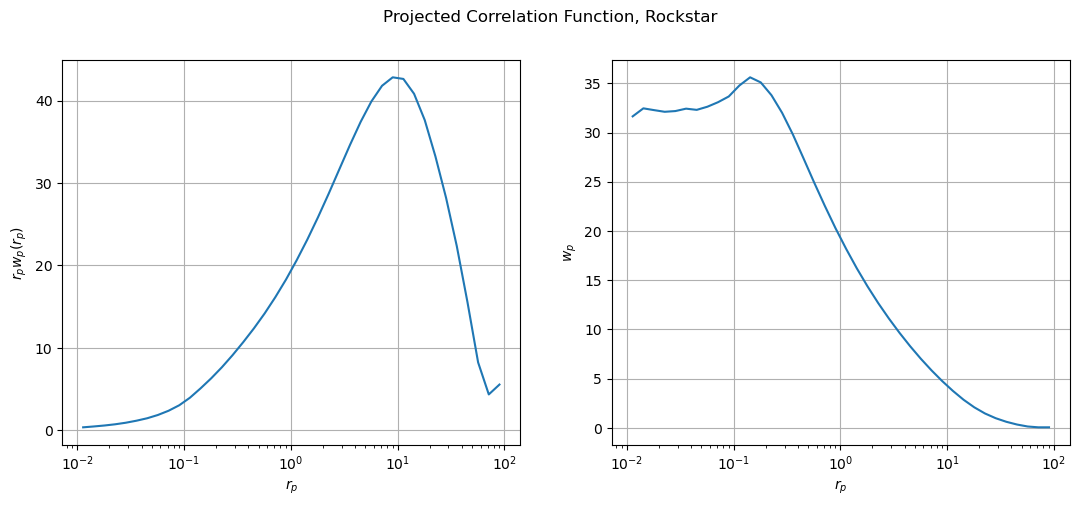

In [27]:
sep_rs = projected_pcf(results_rppi_rs, title='Rockstar')

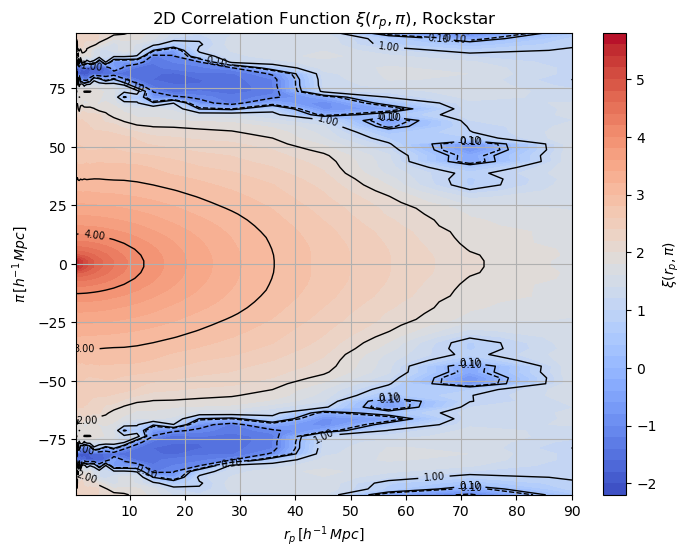

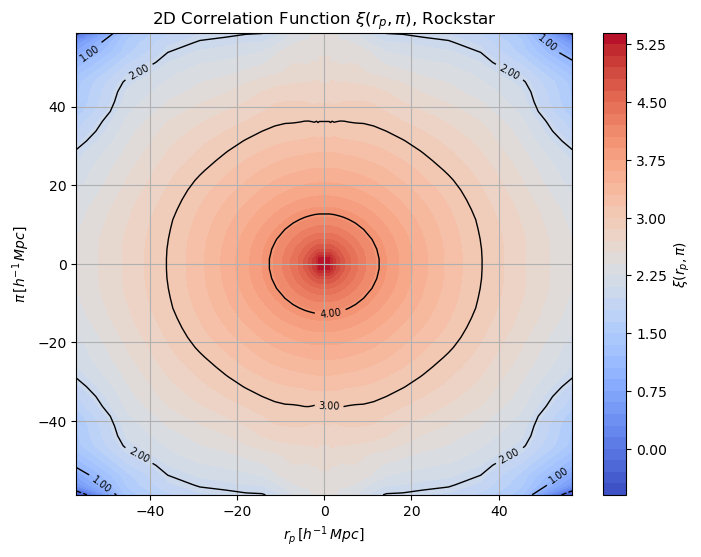

In [28]:
print_xi(results_rppi_rs, pi_lim=100, r_lim=0.3, title='Rockstar')

# print_xi_round_test_nolog(results_rppi_cs, pi_lim=50, r_lim=50, r_lim_min=0.5, title='CompaSO')

print_xi_round(results_rppi_rs, pi_lim=60, r_lim=60, r_lim_min=1, title='Rockstar')


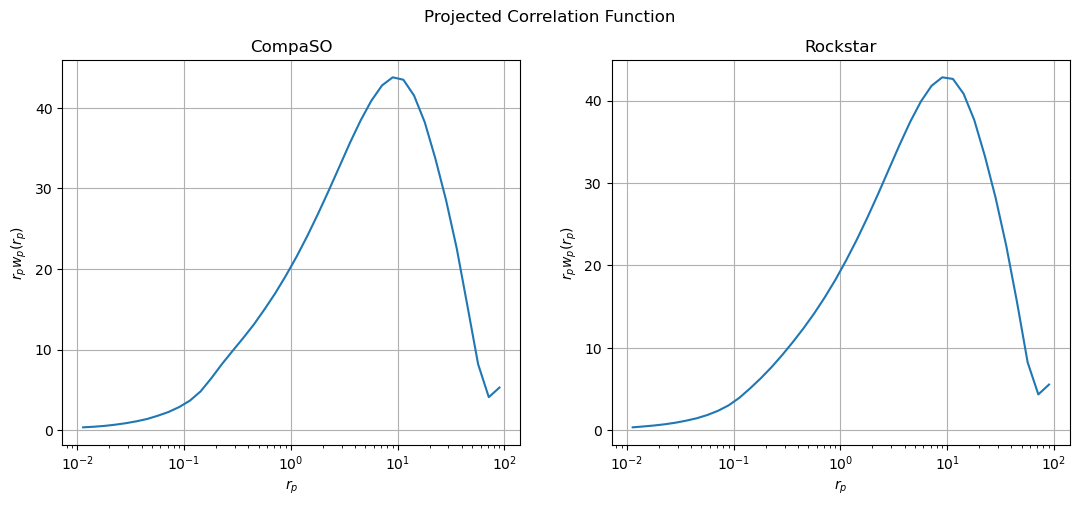

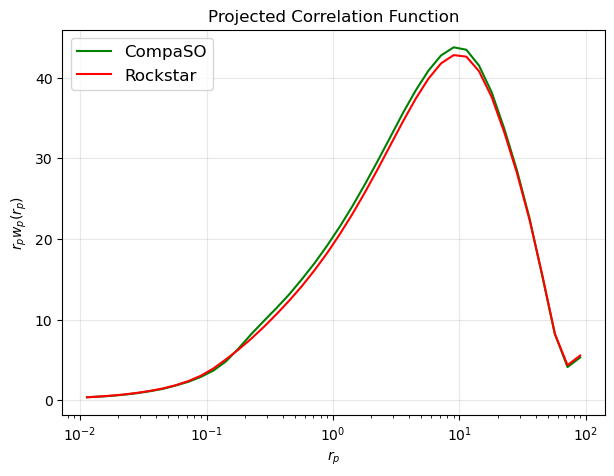

In [29]:
sep_rs, wp_rs = results_rppi_rs(pimax=None, return_sep=True) # sep is r_p
sep_cs, wp_cs = results_rppi_cs(pimax=None, return_sep=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharex=False, sharey=False, figsize=(13, 5))
fig.suptitle(f'Projected Correlation Function')

ax1.plot(sep_cs, sep_cs * wp_cs)
ax1.set_xscale('log')
ax1.set_xlabel(r'$r_{p}$')
ax1.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax1.set_title("CompaSO")
ax1.grid(True)

ax2.plot(sep_rs, sep_rs * wp_rs)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'$r_{p}$')
ax2.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax2.set_title("Rockstar")
ax2.grid(True)

plt.show()

plt.figure(figsize=(7, 5))
plt.title(f'Projected Correlation Function')

# Plot CompaSO
plt.plot(sep_cs, sep_cs * wp_cs, label='CompaSO', color='green', linestyle='-')

# Plot Rockstar
plt.plot(sep_rs, sep_rs * wp_rs, label='Rockstar', color='red', linestyle='-')

# Axes and labels
plt.xscale('log')
plt.xlabel(r'$r_{p}$')
plt.ylabel(r'$r_{p} w_{p}(r_{p})$')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

### RSD

In [43]:
## CompaSO

z_sim_cs = hcat.header['Redshift']
id_cs = np.array(hcat_pos['id'])
a_cs = hcat.header['ScaleFactor'] # scale factor

Hz_cs = hcat.header['HubbleNow'] * 100

velocities_cs = np.array(hcat_pos['v_L2com'])

z_rsd_cs, delta_z_cs = rsd_effect(a_cs, positions_cs, velocities_cs, Hz_cs, name='CompaSO')

## Rockstar

H0 = 100
Om_rs = get_variable(file_path_rs, name='Om')
Ol_rs = get_variable(file_path_rs, name='Ol')
z_sim_rs = extract_redshift_from_path(file_path_rs)
a_rs = Ol_rs = get_variable(file_path_rs, name='SCALE_NOW')

Hz_rs = H0 * np.sqrt(Om_rs * (1+z_sim_rs)**3 + Ol_rs)

print('Hz :', Hz_rs, '\n', 'Om_rs :', Om_rs, '\n', 'Ol_rs :', Ol_rs, '\n', 'z_sim_rs :', z_sim_rs, '\n', 'a_rs :', a_rs, '\n',)

z_rsd_rs, delta_z_rs = rsd_effect(a_rs, positions_RS, velocities_RS, Hz_rs, name='Rockstar')


Shape of velocities: (48359672, 3)
Shape of positions: (48359672, 3) 

Hubble constant Hz: 132.23392151789199 

Hz : 131.54618960654088 
 Om_rs : 0.315192 
 Ol_rs : 0.666667 
 z_sim_rs : 0.5 
 a_rs : 0.666667 

Shape of velocities: (93318302, 3)
Shape of positions: (93318302, 3) 

Hubble constant Hz: 131.54618960654088 



In [44]:
# Créer des colonnes FITS
col1 = fits.Column(name='z_rsd_rs', array=z_rsd_rs, format='D')  # 'D' = float64
col2 = fits.Column(name='z_rsd_cs', array=z_rsd_cs, format='D')

# Créer une table
cols = fits.ColDefs([col1, col2])
hdu = fits.BinTableHDU.from_columns(cols)

# Sauver dans un fichier FITS
hdu.writeto('/pscratch/sd/g/guittonm/z_rsd_tot.fits', overwrite=True)

with fits.open('/pscratch/sd/g/guittonm/z_rsd_tot.fits') as hdul:
    data = hdul[1].data  # [0] est le header primaire vide, [1] est la table

    z_rsd_rs = data['z_rsd_rs']
    z_rsd_cs = data['z_rsd_cs']

print(z_rsd_rs[:5])

[93.31839752 93.51161194 90.45804596 84.72021484 86.19363403]


In [45]:
# ## CompaSo
 
# results_rppi_cs_rsd = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=55,
#     boxsize=boxsize_cs,
#     los='z'
# )

# pi_cs_rsd = results_rppi_cs_rsd.sepavg(axis=1) 
# xi_rppi_cs_rsd = results_rppi_cs_rsd.corr

In [46]:
# np.savez('/pscratch/sd/g/guittonm/rppi_cs_rsd_tot.npz', 
#          results_rppi_cs_rsd=results_rppi_cs_rsd,
#          pi_cs_rsd=pi_cs_rsd, 
#          xi_rppi_cs_rsd=xi_rppi_cs_rsd)

data_rppi_cs_rsd = np.load('/pscratch/sd/g/guittonm/rppi_cs_rsd_tot.npz', allow_pickle=True)

results_rppi_cs_rsd = data_rppi_cs_rsd['results_rppi_cs_rsd'].item()
pi_cs_rsd = data_rppi_cs_rsd['pi_cs_rsd']
xi_rppi_cs_rsd = data_rppi_cs_rsd['xi_rppi_cs_rsd']

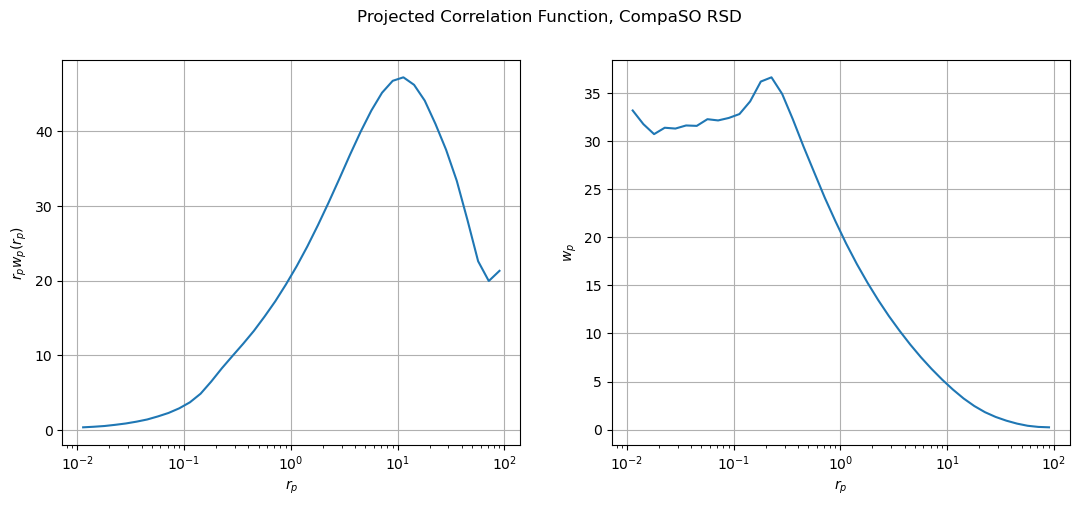

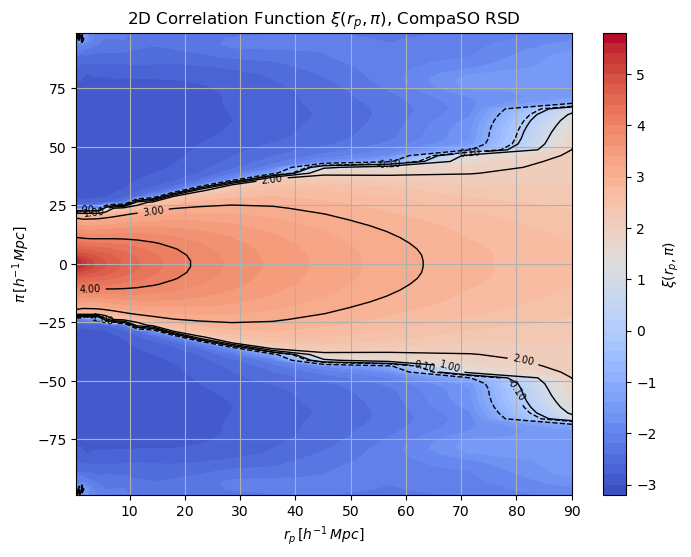

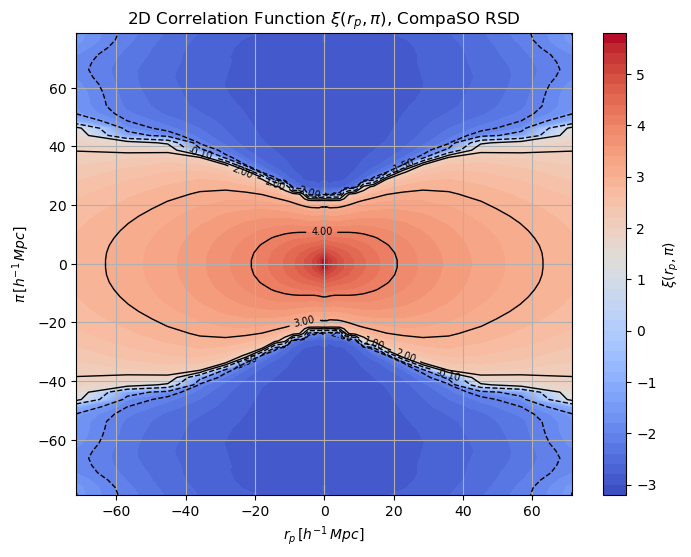

In [47]:
sep_cs_rsd = projected_pcf(results_rppi_cs_rsd, title='CompaSO RSD')

print_xi(results_rppi_cs_rsd, pi_lim=100, r_lim=0.3, title='CompaSO RSD')
print_xi_round(results_rppi_cs_rsd, pi_lim=80, r_lim=80, r_lim_min=0.3, title='CompaSO RSD')

In [48]:
# ## Rockstar

# results_rppi_rs_rsd = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
#     nthreads=55,  
#     boxsize=boxsize_rs,
#     los='z'
# ) 
 
# pi_rs_rsd = results_rppi_rs_rsd.sepavg(axis=1)
# xi_rppi_rs_rsd = results_rppi_rs_rsd.corr 

In [49]:
# np.savez('/pscratch/sd/g/guittonm/rppi_rs_rsd_pid_tot.npz', 
#          results_rppi_rs_rsd=results_rppi_rs_rsd,
#          pi_rs_rsd=pi_rs_rsd, 
#          xi_rppi_rs_rsd=xi_rppi_rs_rsd)

data_rppi_rs_rsd = np.load('/pscratch/sd/g/guittonm/rppi_rs_rsd_pid_tot.npz', allow_pickle=True)

results_rppi_rs_rsd = data_rppi_rs_rsd['results_rppi_rs_rsd'].item()
pi_rs_rsd = data_rppi_rs_rsd['pi_rs_rsd']
xi_rppi_rs_rsd = data_rppi_rs_rsd['xi_rppi_rs_rsd']

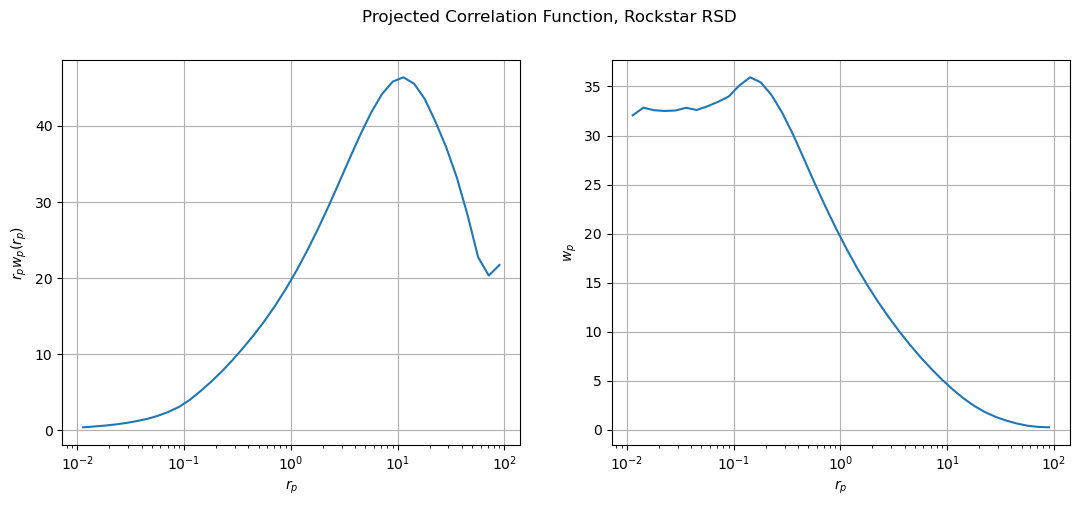

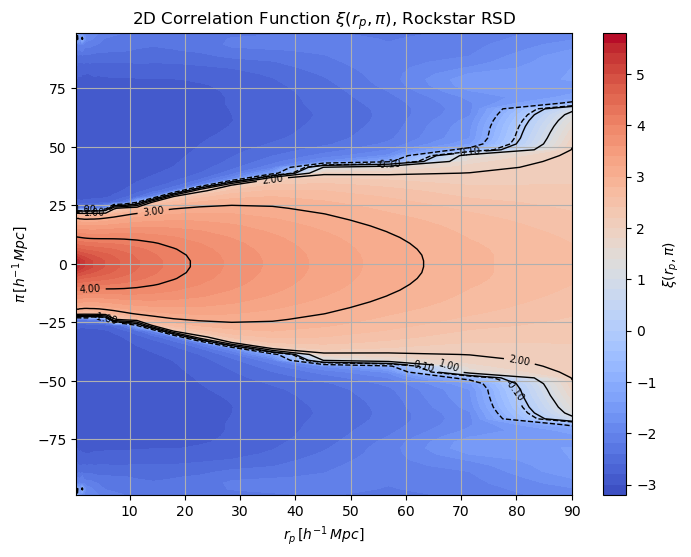

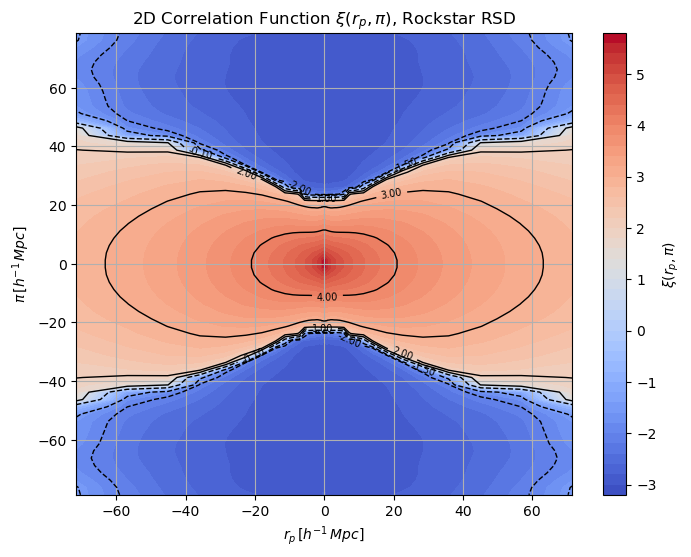

In [50]:
sep_rs_rsd = projected_pcf(results_rppi_rs_rsd, title='Rockstar RSD')

print_xi(results_rppi_rs_rsd, pi_lim=100, r_lim=0.3, title='Rockstar RSD')
print_xi_round(results_rppi_rs_rsd, pi_lim=80, r_lim=80, r_lim_min=0.3, title='Rockstar RSD')

### 2PCF comparison

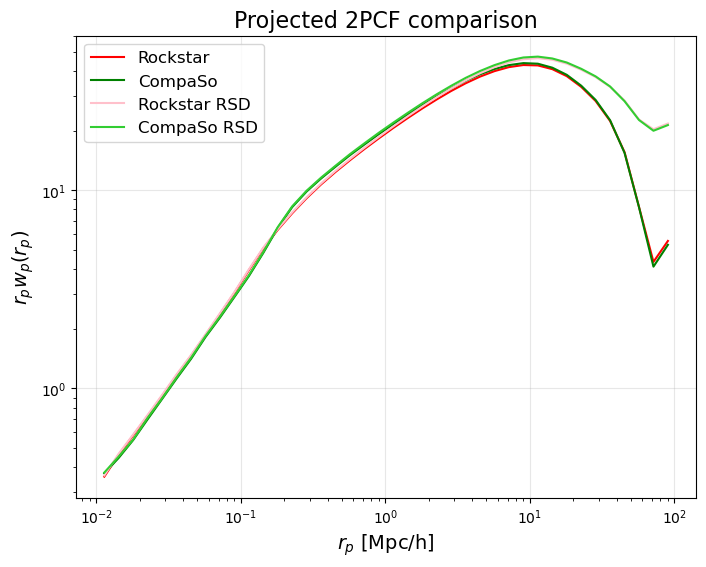

In [61]:
pcf_results = [results_rppi_rs, results_rppi_cs, results_rppi_rs_rsd, results_rppi_cs_rsd]
legends_pcf = ['Rockstar', 'CompaSo', 'Rockstar RSD', 'CompaSo RSD']
colors_pcf= ['red', 'green', 'pink', 'limegreen']

compa_pcf(pcf_results, legends=legends_pcf, colors=colors_pcf, title="Projected 2PCF comparison", mask_range=(0.01,100))

# Bias

In [56]:
# fraction = 0.02  # % of the data

# # Create a binary mask to select 10% of the data
# mask = np.random.rand(positions_mm.shape[0]) < fraction
 
# # Apply the mask
# positions_mm_sampled = positions_mm[mask]

# if positions_mm_sampled.shape[1] == 3:  # Check that it's a 2D table with 3 columns
#     positions_mm_sampled = [positions_mm_sampled[:, 0], positions_mm_sampled[:, 1], positions_mm_sampled[:, 2]]  # Separate x, y, z

In [57]:
# np.savez('/pscratch/sd/g/guittonm/pos_mm.npz', 
#          positions_mm_sampled=positions_mm_sampled)    
 
data_pos_mm = np.load('/pscratch/sd/g/guittonm/pos_mm.npz') 
 
positions_mm_sampled = data_pos_mm['positions_mm_sampled'] 

In [58]:
# ## SMU

# results_smu_mm = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Distance markers for bins
#     data_positions1=positions_mm_sampled,  # Particles positions
#     boxsize=boxsize_cs,  
#     los='z',
#     nthreads=45
# )

# xi_mm = results_smu_mm.corr  

In [59]:
# np.savez('/pscratch/sd/g/guittonm/smu_mm.npz',  
#          results_smu_mm=results_smu_mm,
#          xi_mm=xi_mm)    
 
data_smu_mm = np.load('/pscratch/sd/g/guittonm/smu_mm.npz', allow_pickle=True)
 
results_smu_mm = data_smu_mm['results_smu_mm'].item()  
xi_mm = data_smu_mm['xi_mm'] 

In [60]:
r_mm_mono, xi_mm_mono = results_smu_mm(ells=(0,), return_sep=True)

## Quadrupoles

In [61]:
r_cs_quad, xi_cs_quad = results_smu_cs(ells=(2,), return_sep=True)
r_rs_quad, xi_rs_quad = results_smu_rs(ells=(2,), return_sep=True)
r_mm_quad, xi_mm_quad = results_smu_mm(ells=(2,), return_sep=True)

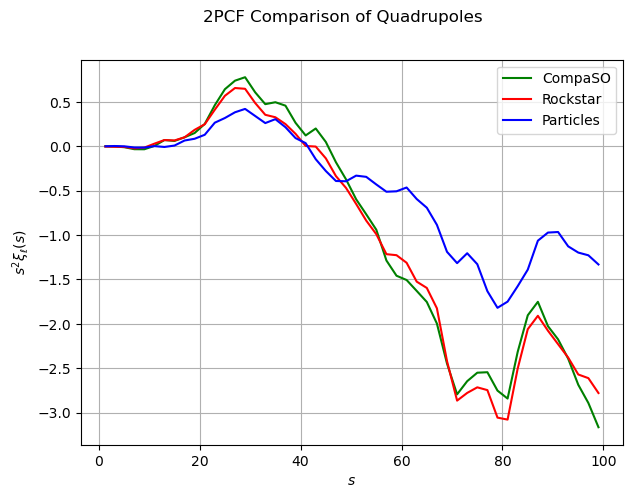

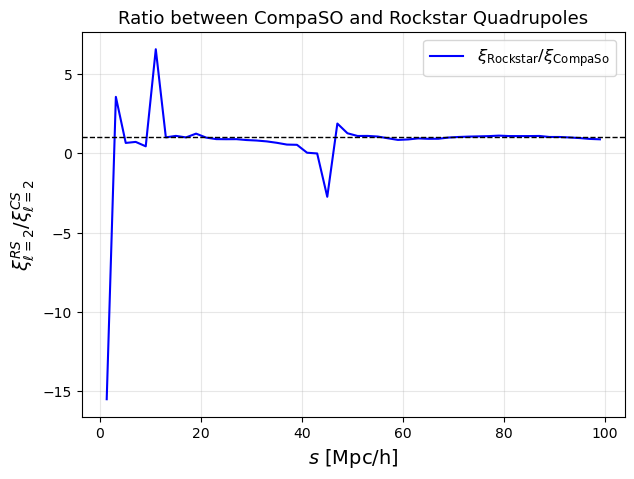

In [62]:
print_chosen_multipole(
    [r_cs_quad, r_rs_quad, r_mm_quad], 
    [xi_cs_quad, xi_rs_quad, xi_mm_quad], 
    ["CompaSO", "Rockstar", "Particles"], 
    "Quadrupoles",
    colors_list = ['green', 'red', 'blue']
)

plot_multipole_ratio(r_cs_quad, xi_cs_quad, xi_rs_quad, yrange=None, mask_range=None, l='2', title = "Ratio between CompaSO and Rockstar Quadrupoles", label=r"$\xi_{\mathrm{Rockstar}} / \xi_{\mathrm{CompaSo}}$")

## Bias 

In [63]:
bin_edges_exp = [11, 11.2, 11.4, 11.6, 11.8, 12, 12.5, 13, 15]

mass_bins = np.power(10, bin_edges_exp)

In [64]:
print(mass_bins)

[1.00000000e+11 1.58489319e+11 2.51188643e+11 3.98107171e+11
 6.30957344e+11 1.00000000e+12 3.16227766e+12 1.00000000e+13
 1.00000000e+15]


### All halos

In [ ]:
## CompaSo

positions_cs_all = np.array(hcat_pos['x_L2com'])
positions_cs_all = positions_cs_all.astype(np.float64)

print("Shape of positions:", positions_cs_all.shape)
x_cs_all, y_cs_all, z_cs_all = positions_cs_all[:, 0], positions_cs_all[:, 1], positions_cs_all[:, 2]

## Rockstar

# positions_RS

NameError: name 'hcat_filtered' is not defined

In [73]:
# print('CompaSo')
# bias_mono_cs, bias_quad_cs = bias_wrt_mass(mass_bins, Mhalos_filtered_CS, positions_cs_all, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs.npz")
# print('\n', 'Rockstar')
# bias_mono_rs, bias_quad_rs = bias_wrt_mass(mass_bins, Mhalos_filtered_RS, positions_RS, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_pid.npz")

In [ ]:
# Charger le fichier _pid.npz
data_cs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs.npz")
data_rs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_pid.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs.files)
print(data_rs.files)

# Extraire les données
mass_bins_cs = data_cs["mass_bins"]  # Bins de masse
r_hh_all_cs = data_cs["r_hh_all"]  # Valeurs de r pour chaque bin
xi_hh_mono_all_cs = data_cs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
bias_by_r_mono_all_cs = data_cs["bias_by_r_mono_all"]
bias_mono_cs =  data_cs["bias_by_mass_mono"]

mass_bins_rs = data_rs["mass_bins"]  # Bins de masse
r_hh_all_rs = data_rs["r_hh_all"]  # Valeurs de r pour chaque bin
xi_hh_mono_all_rs = data_rs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
bias_by_r_mono_all_rs = data_rs["bias_by_r_mono_all"]
bias_mono_rs =  data_rs["bias_by_mass_mono"]

['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_mass_mono', 'bias_by_mass_quad', 'bias_by_r_mono_all', 'bias_by_r_quad_all']
['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_mass_mono', 'bias_by_mass_quad', 'bias_by_r_mono_all', 'bias_by_r_quad_all']


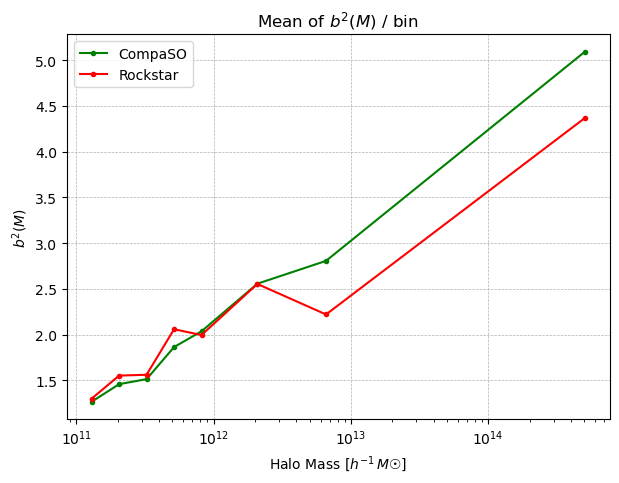

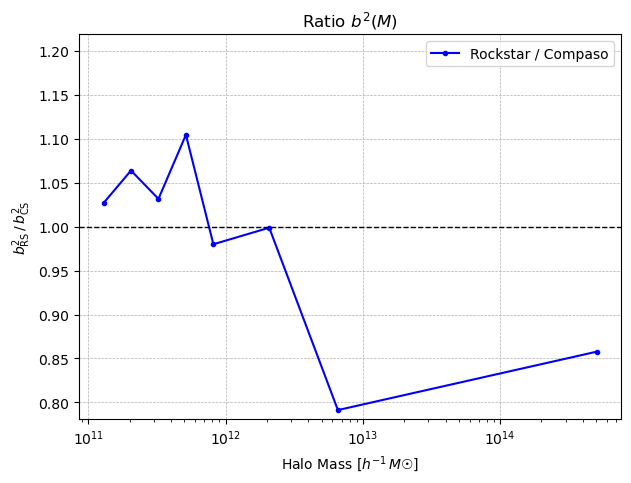

In [75]:
mass_centers_cs = [item[0] for item in bias_mono_cs]
bias_values_cs = [item[1] for item in bias_mono_cs]

mass_centers_rs = [item[0] for item in bias_mono_rs]
bias_values_rs = [item[1] for item in bias_mono_rs]

plot_masses_fct(data_list = [bias_values_cs, bias_values_rs],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-','-'],
                ylabel = r'$b^2(M)$',
                title=r"Mean of $b^2(M)$ / bin",
                scale = 'semilogx', center_around_one=False)

np_bias_values_rs = np.array(bias_values_rs)
np_bias_values_cs = np.array(bias_values_cs)

bias_ratio = np_bias_values_rs / np_bias_values_cs

plot_masses_fct(data_list = [bias_ratio],
                bins_list = [mass_centers_rs],
                colors_list = colors_ratio,
                labels_list = labels_ratio,
                linestyles_list=['-'],
                ylabel = r'$b^2_{\mathrm{RS}} \,/\, b^2_{\mathrm{CS}}$',
                title = r"Ratio $b^2(M)$",
                scale = 'semilogx', center_around_one=True)

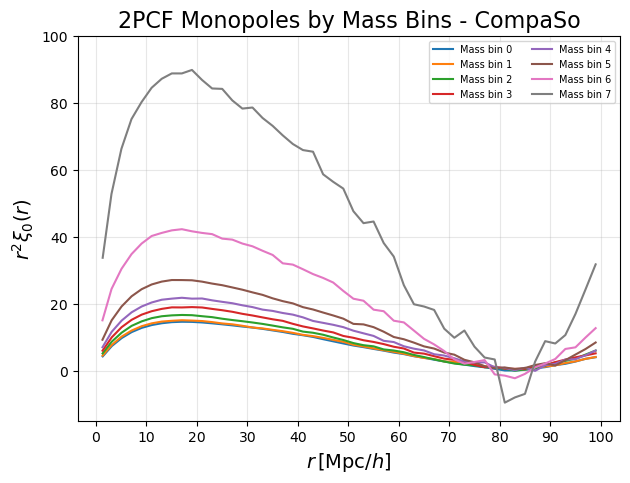

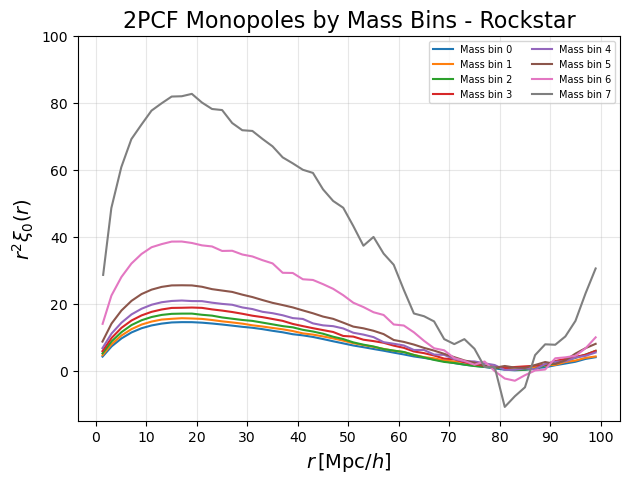

In [76]:
## CompaSo

plot_mass_binned_quantity(
    r_hh_all=r_hh_all_cs, 
    quantity_all=xi_hh_mono_all_cs,  
    mass_bins=mass_bins,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title='2PCF Monopoles by Mass Bins - CompaSo',
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation spécifique pour la 2PCF
    mask_range=(0,100),
    yrange=(-15,100),
    scalex=None,
    scaley=None
)

## Rockstar 

plot_mass_binned_quantity(
    r_hh_all=r_hh_all_rs, 
    quantity_all=xi_hh_mono_all_rs,  
    mass_bins=mass_bins,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title='2PCF Monopoles by Mass Bins - Rockstar',
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation spécifique pour la 2PCF
    mask_range=(0,100),
    yrange=(-15,100),
    scalex=None,
    scaley=None
)

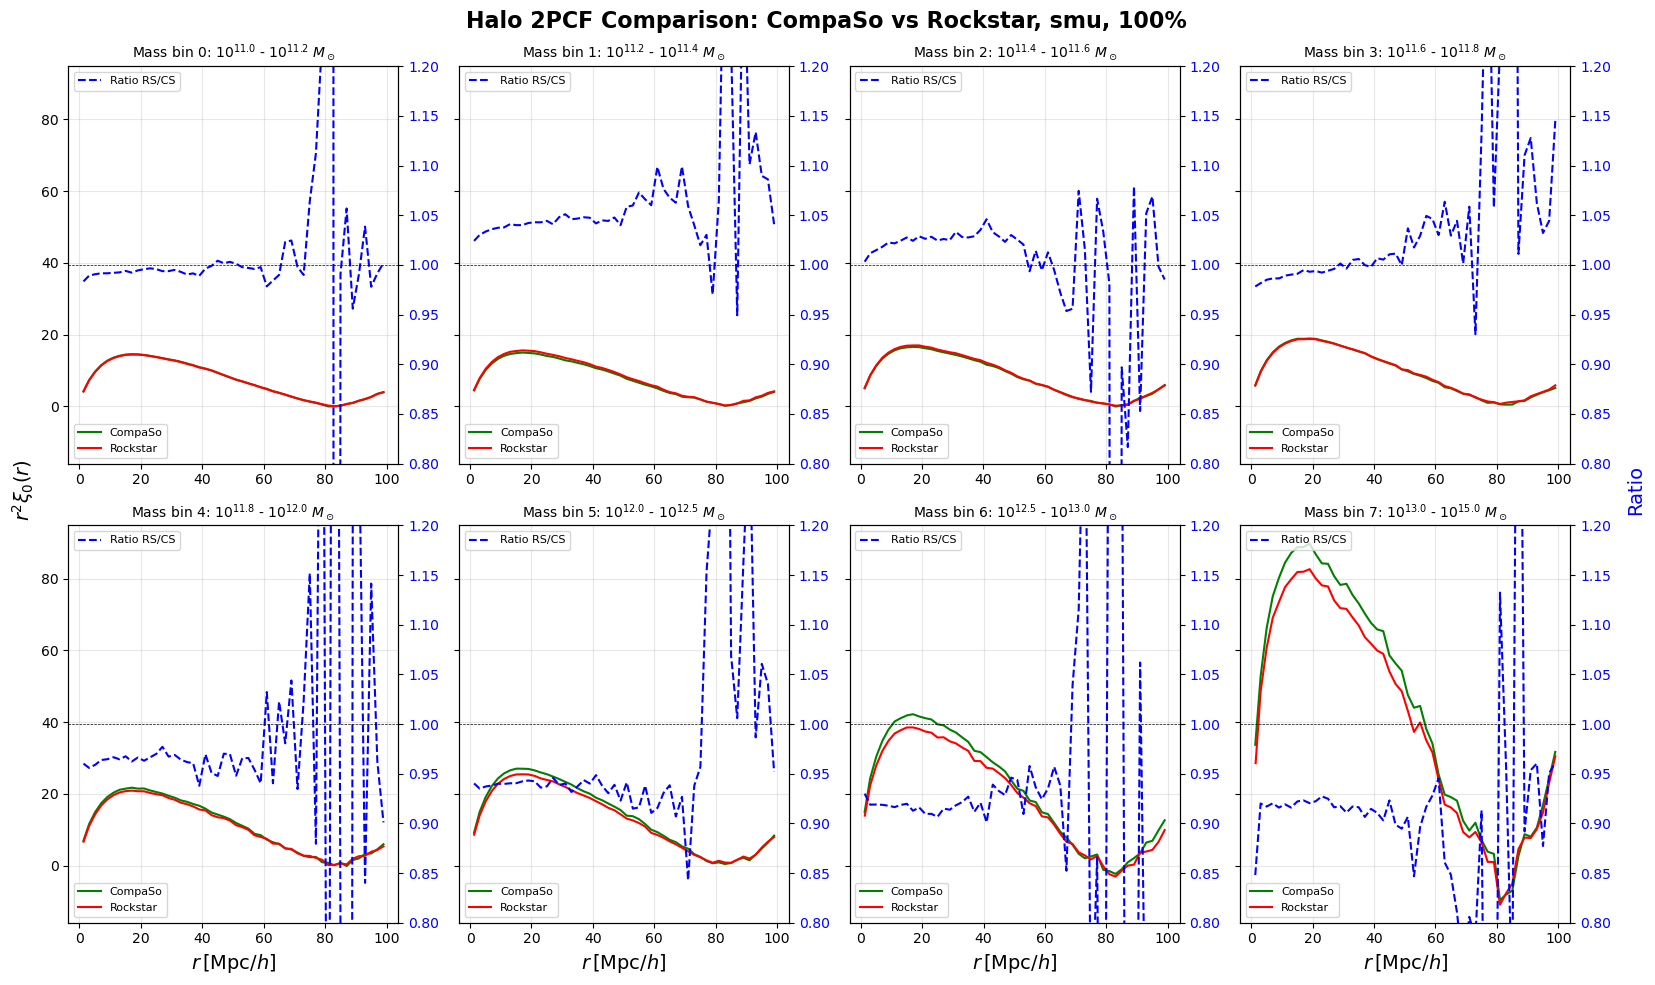

In [77]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=xi_hh_mono_all_cs, errors_cs=False,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=xi_hh_mono_all_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title="Halo 2PCF Comparison: CompaSo vs Rockstar, smu, 100%",
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation pour la 2PCF
    rows=2,  # Affichage sur 2 lignes,
    mask_range=(0,100), ratio_yrange=(0.8,1.2),
    scaley=None, scalex=None,
    ratio_leg='upper left', leg_pos='lower left'
)

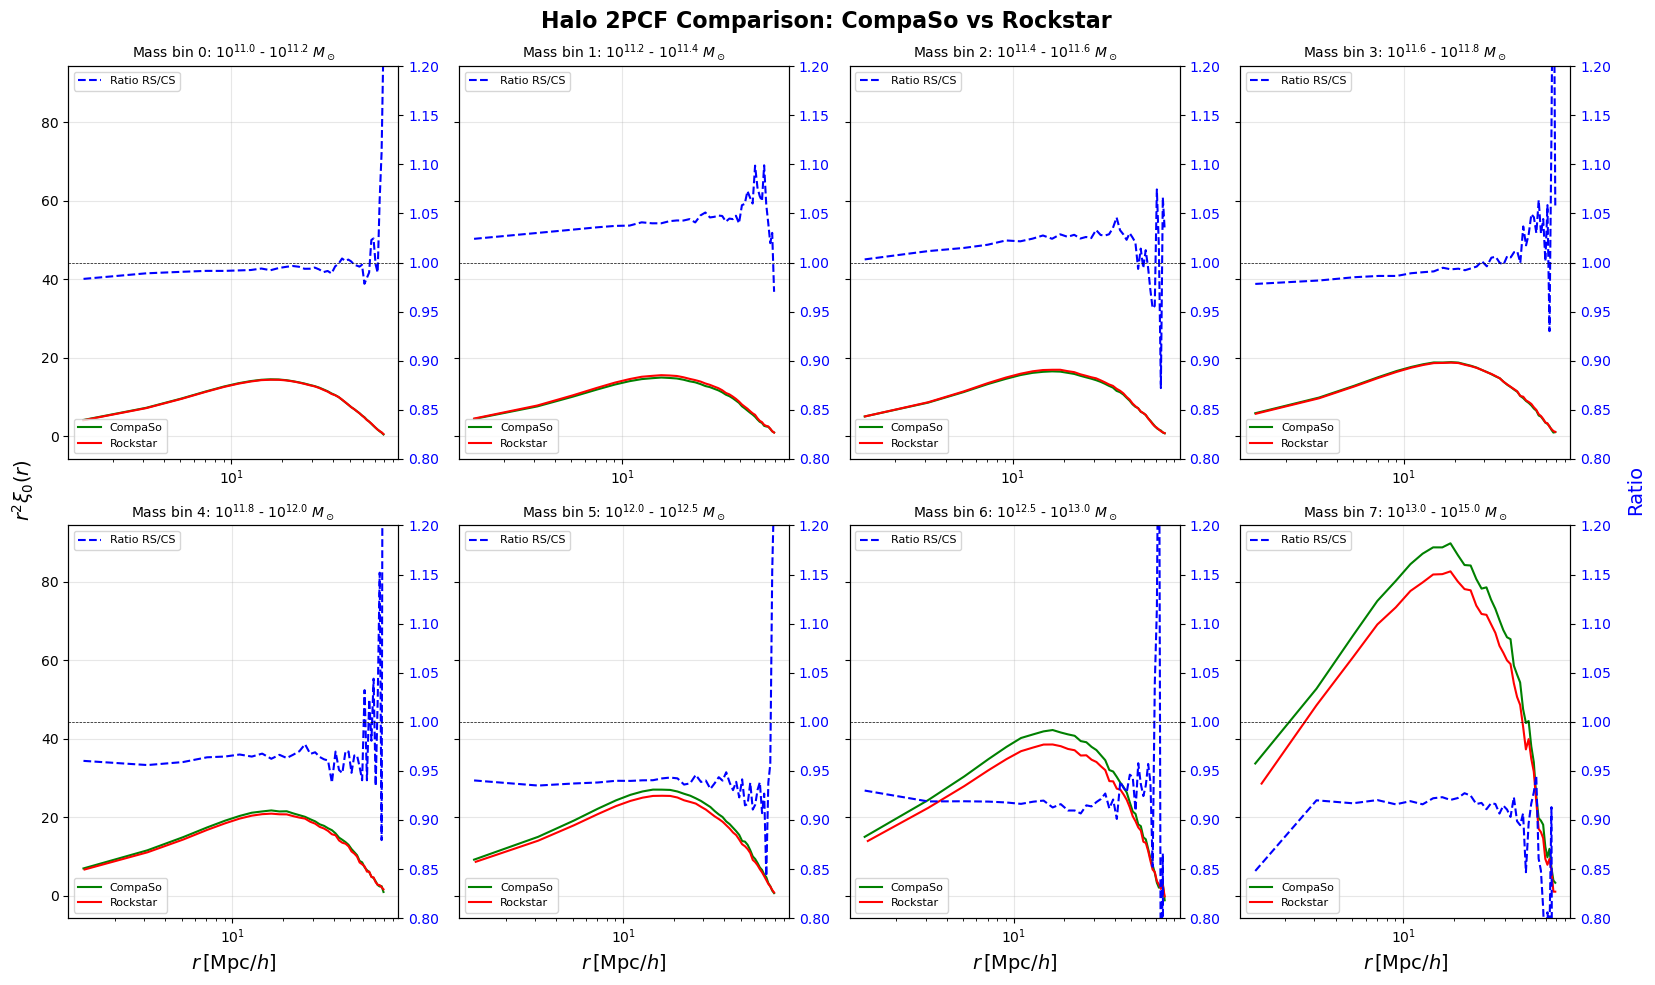

In [78]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=xi_hh_mono_all_cs, errors_cs=False,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=xi_hh_mono_all_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title="Halo 2PCF Comparison: CompaSo vs Rockstar",
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation pour la 2PCF
    rows=2,  # Affichage sur 2 lignes,
    mask_range=(0,80), ratio_yrange=(0.8,1.2),
    scaley=None, scalex='log',
    ratio_leg='upper left', leg_pos='lower left'
)

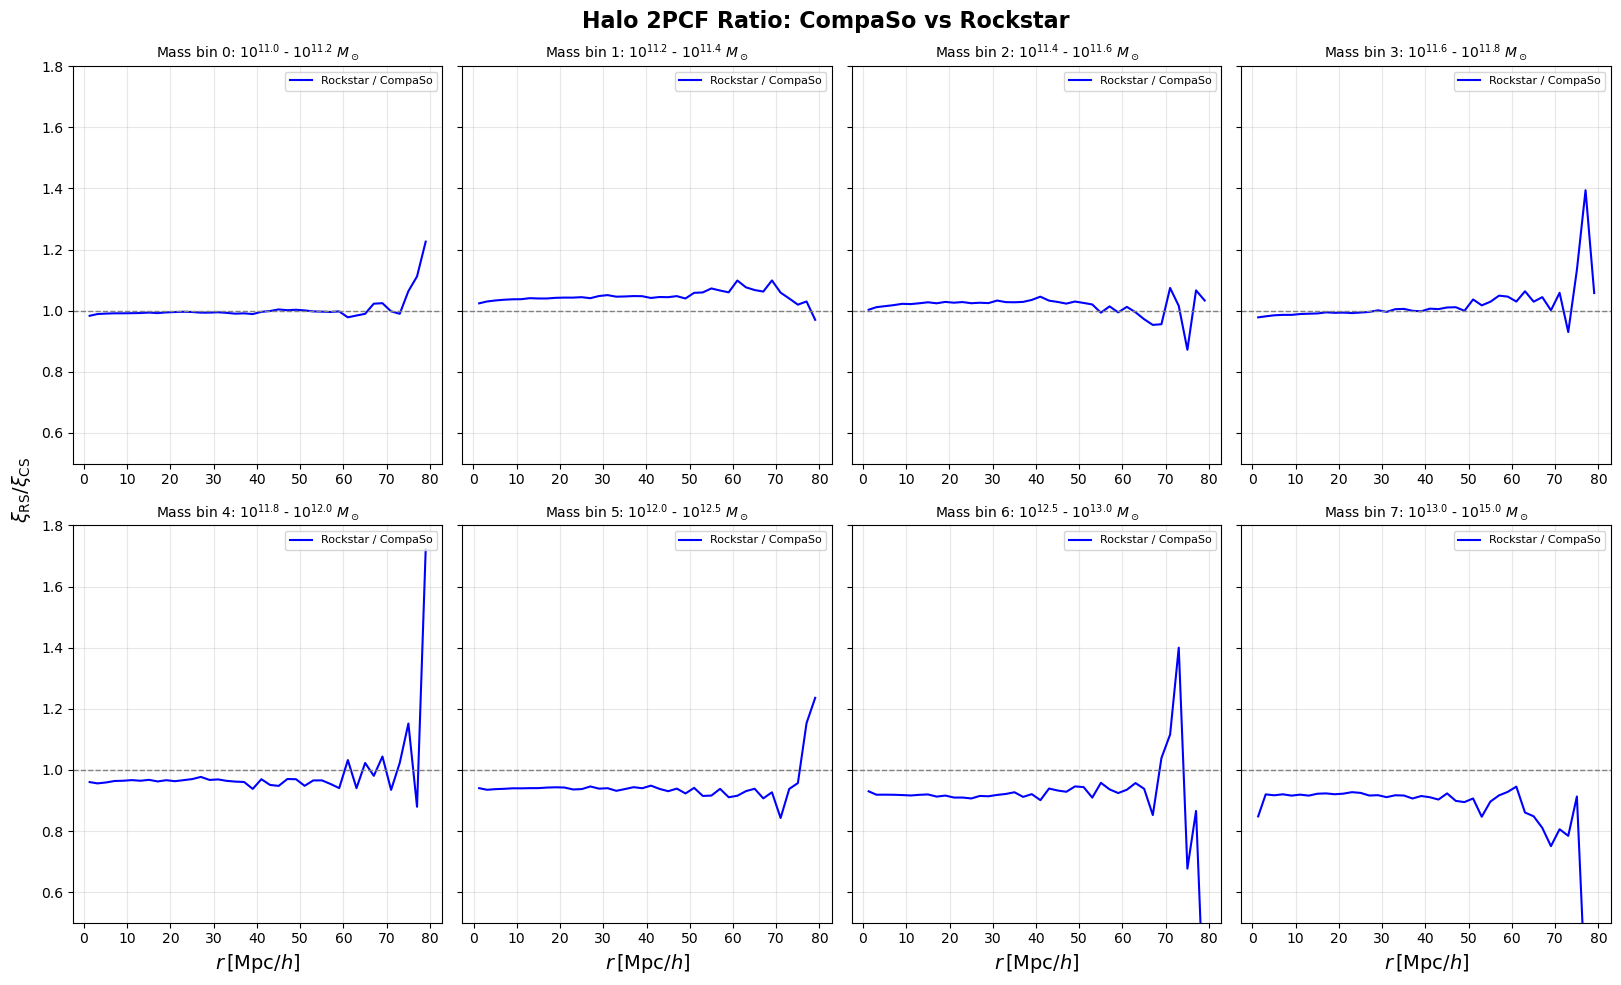

In [79]:
plot_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=xi_hh_mono_all_cs,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=xi_hh_mono_all_rs,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$\xi_{\mathrm{RS}} / \xi_{\mathrm{CS}}$',
    title="Halo 2PCF Ratio: CompaSo vs Rockstar",
    apply_transformation=lambda r, q: r * r * q.squeeze(),
    yrange=(0.5, 1.8),
    mask_range=(0,80),
    rows=2  # Affichage sur 2 lignes
)

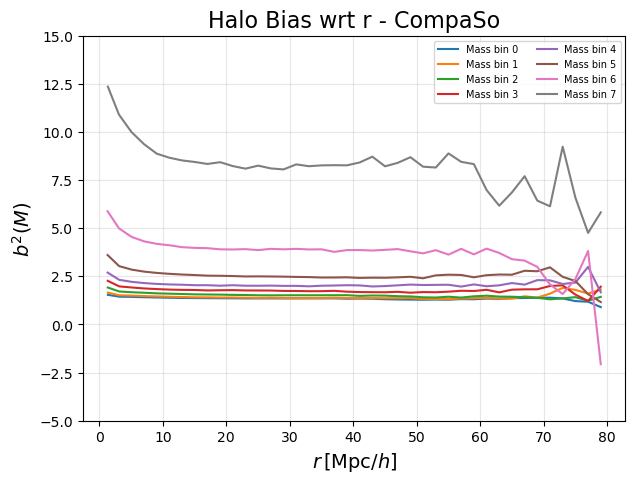

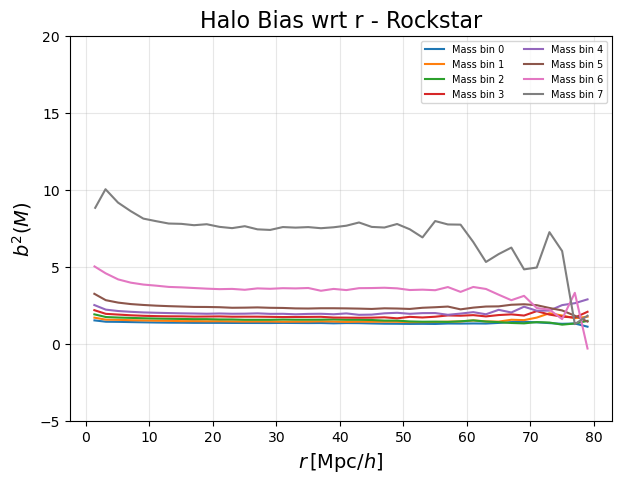

In [80]:
## CompaSo
plot_mass_binned_quantity(
    r_hh_all=r_hh_all_cs, 
    quantity_all=bias_by_r_mono_all_cs,  
    mass_bins=mass_bins,
    ylabel=r'$b^2(M)$',
    title='Halo Bias wrt r - CompaSo',
    mask_range=(0,80),
    yrange=(-5,15),
    scalex=None,
    scaley=None
)

## Rockstar
plot_mass_binned_quantity(
    r_hh_all=r_hh_all_rs, 
    quantity_all=bias_by_r_mono_all_rs,  
    mass_bins=mass_bins,
    ylabel=r'$b^2(M)$',
    title='Halo Bias wrt r - Rockstar',
    mask_range=(0,80),
    yrange=(-5,20),
    scalex=None,
    scaley=None
)

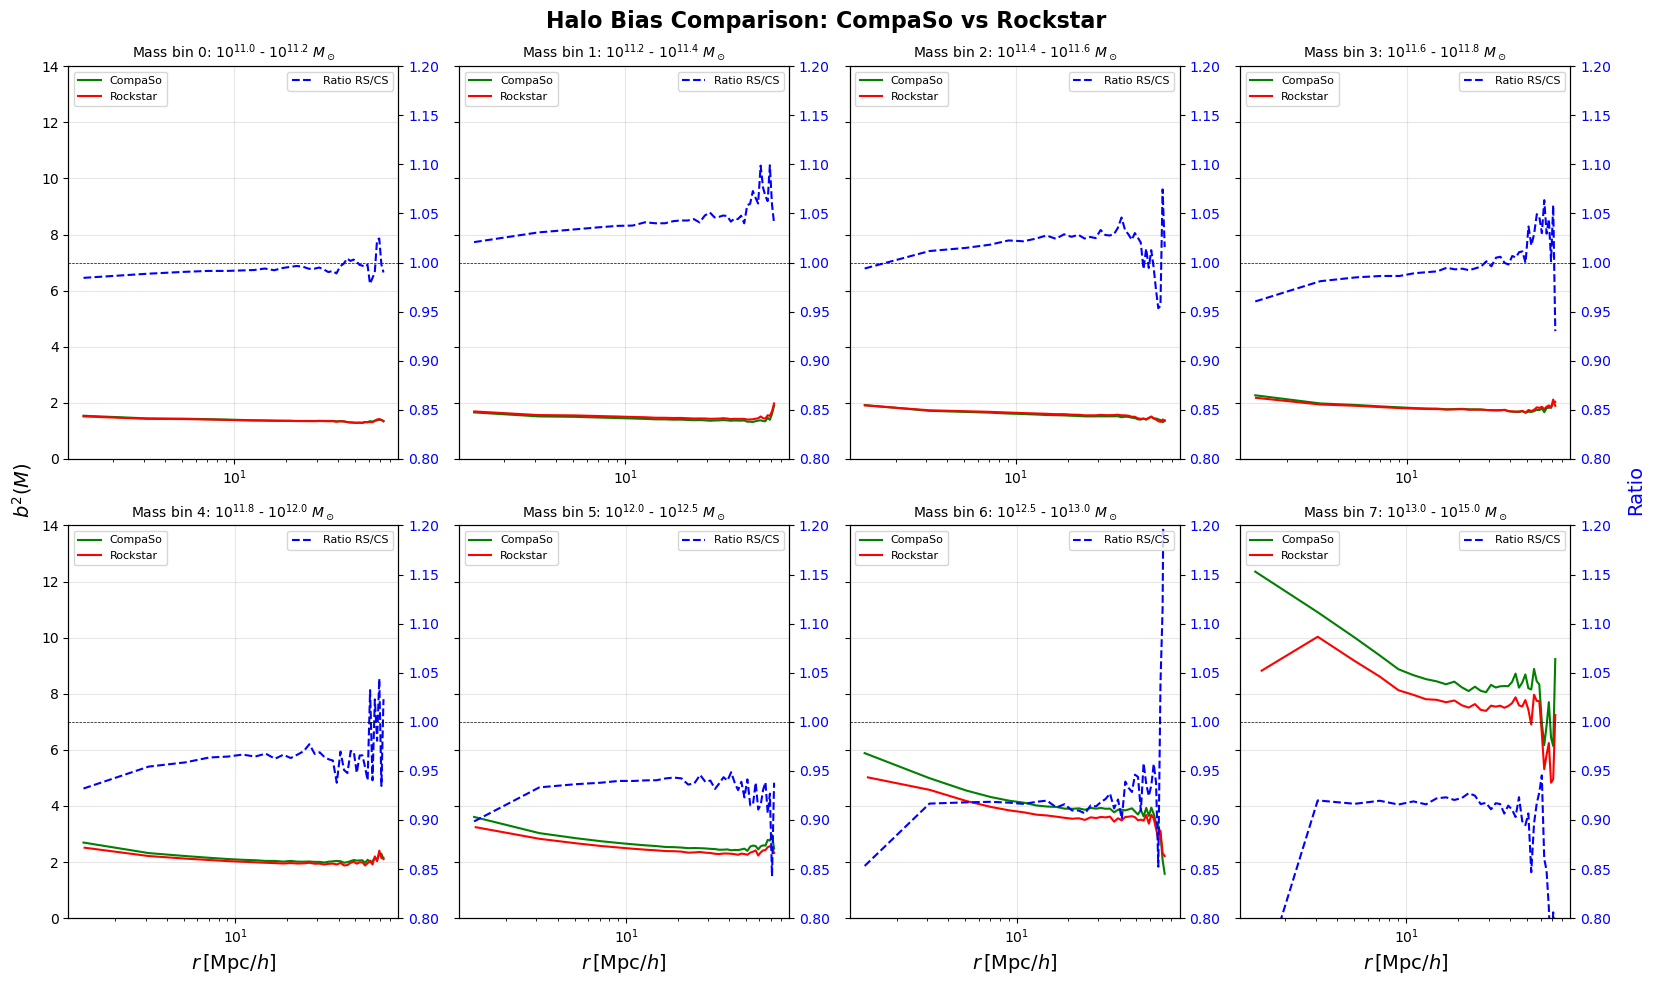

In [81]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=bias_by_r_mono_all_cs, errors_cs=False,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=bias_by_r_mono_all_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2, scaley=None,
    yrange = (0, 14), ratio_yrange=(0.8,1.2),
    mask_range = (0, 75), leg_pos='upper left', ratio_leg='upper right'
)

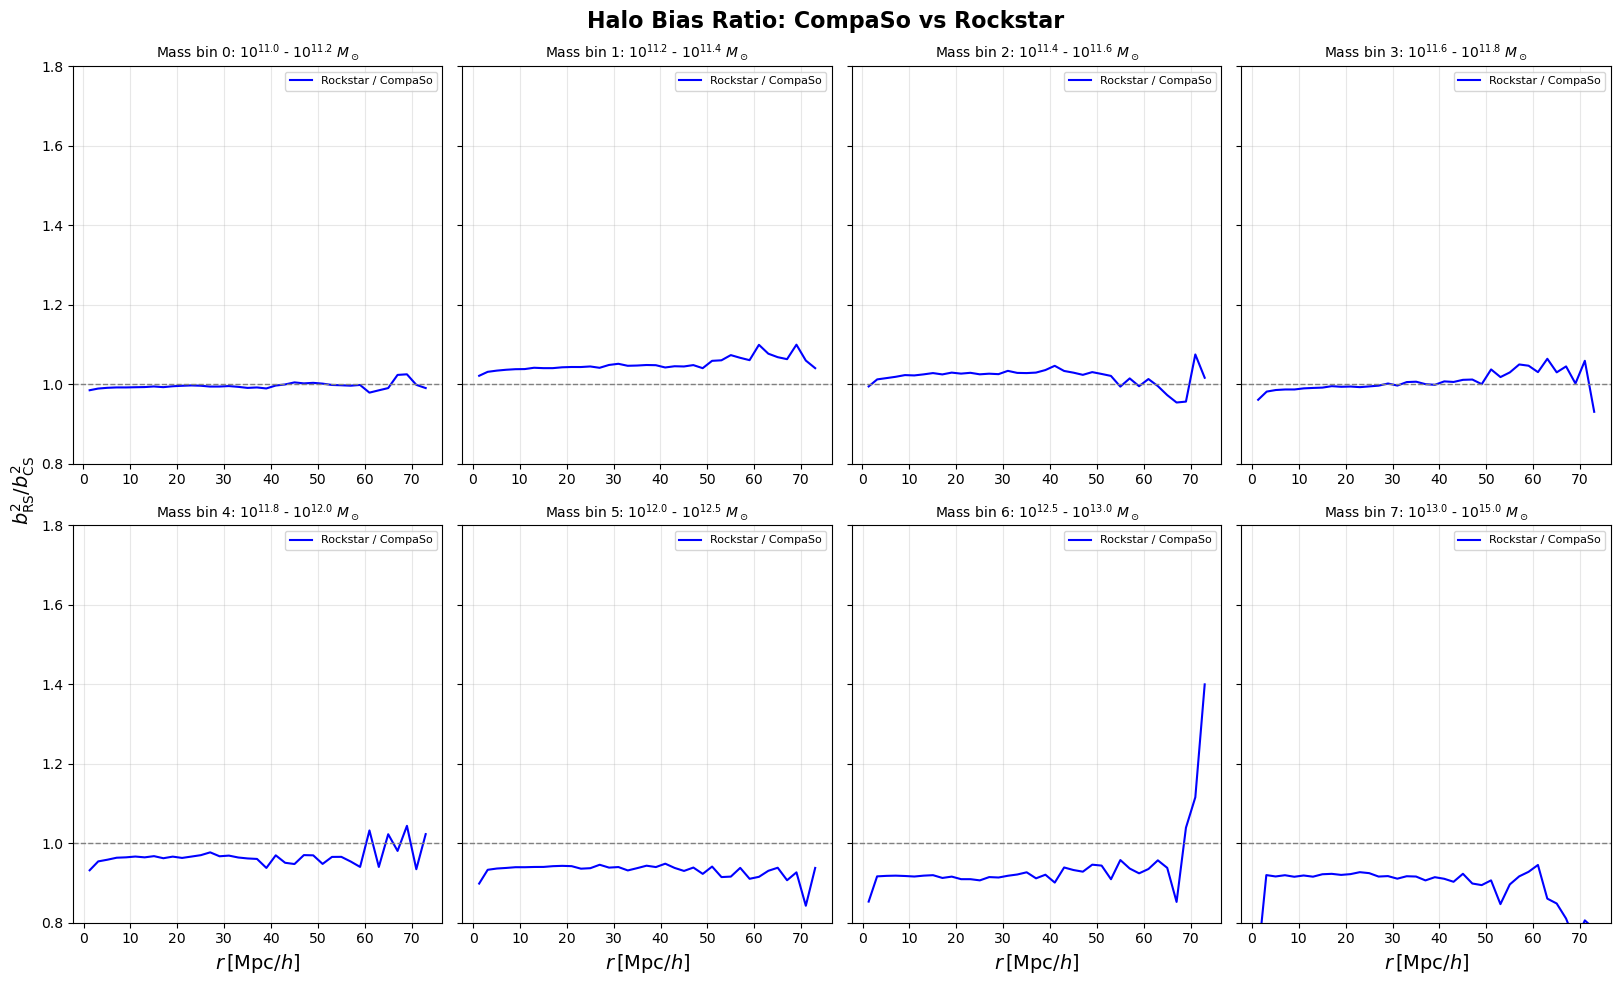

In [82]:
plot_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=bias_by_r_mono_all_cs,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=bias_by_r_mono_all_rs,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2_{\mathrm{RS}} / b^2_{\mathrm{CS}}$',
    title="Halo Bias Ratio: CompaSo vs Rockstar",
    yrange=(0.8, 1.8),
    mask_range=(0,75),
    rows=2  # Affichage sur 2 lignes
)

### RPPI per mass bin

In [66]:
# wp_all_cs, rp_all_cs = xi_wrt_mass(mass_bins, Mhalos_filtered_CS, positions_cs_all, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_cs_bs.npz", mask_range=(None, None), nthreads=32)

# wp_all_rs, rp_all_rs = xi_wrt_mass(mass_bins, Mhalos_filtered_RS, positions_RS, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_rs_bs_pid.npz", mask_range=(None, None), nthreads=32)

In [67]:
# Charger le fichier _pid.npz
data_cs_rppi = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_cs_bs.npz")
data_rs_rppi = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_rs_bs_pid.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_rppi.files)
print(data_rs_rppi.files)

# Extraire les données
mass_bins_cs_rppi = data_cs_rppi["mass_bins"]  # Bins de masse
rp_all_cs = data_cs_rppi["rp_all"] 
wp_all_cs = data_cs_rppi["wp_all"] 

mass_bins_rs_rppi = data_rs_rppi["mass_bins"]  # Bins de masse
rp_all_rs = data_rs_rppi["rp_all"]  
wp_all_rs = data_rs_rppi["wp_all"]

['mass_bins', 'rp_all', 'wp_all']
['mass_bins', 'rp_all', 'wp_all']


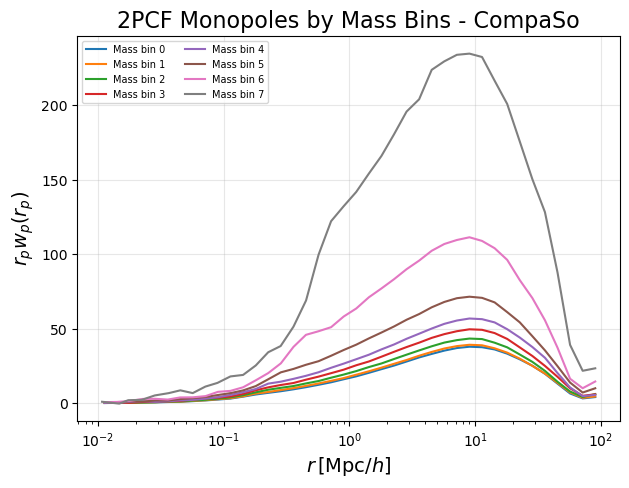

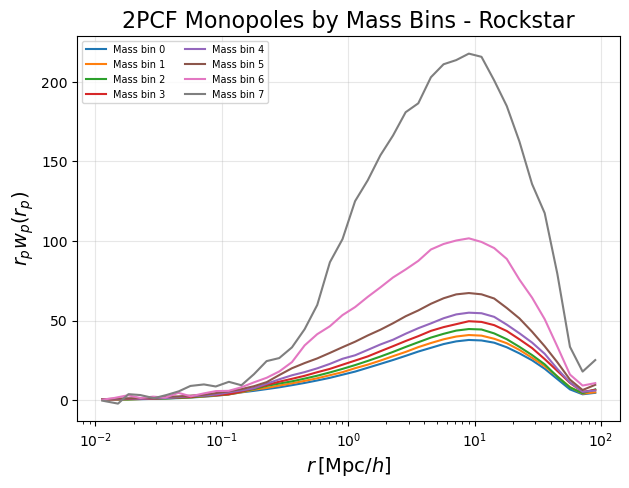

In [68]:
plot_mass_binned_quantity(
    r_hh_all=rp_all_cs, 
    quantity_all=wp_all_cs,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins - CompaSo',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

plot_mass_binned_quantity(
    r_hh_all=rp_all_rs, 
    quantity_all=wp_all_rs,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins - Rockstar',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

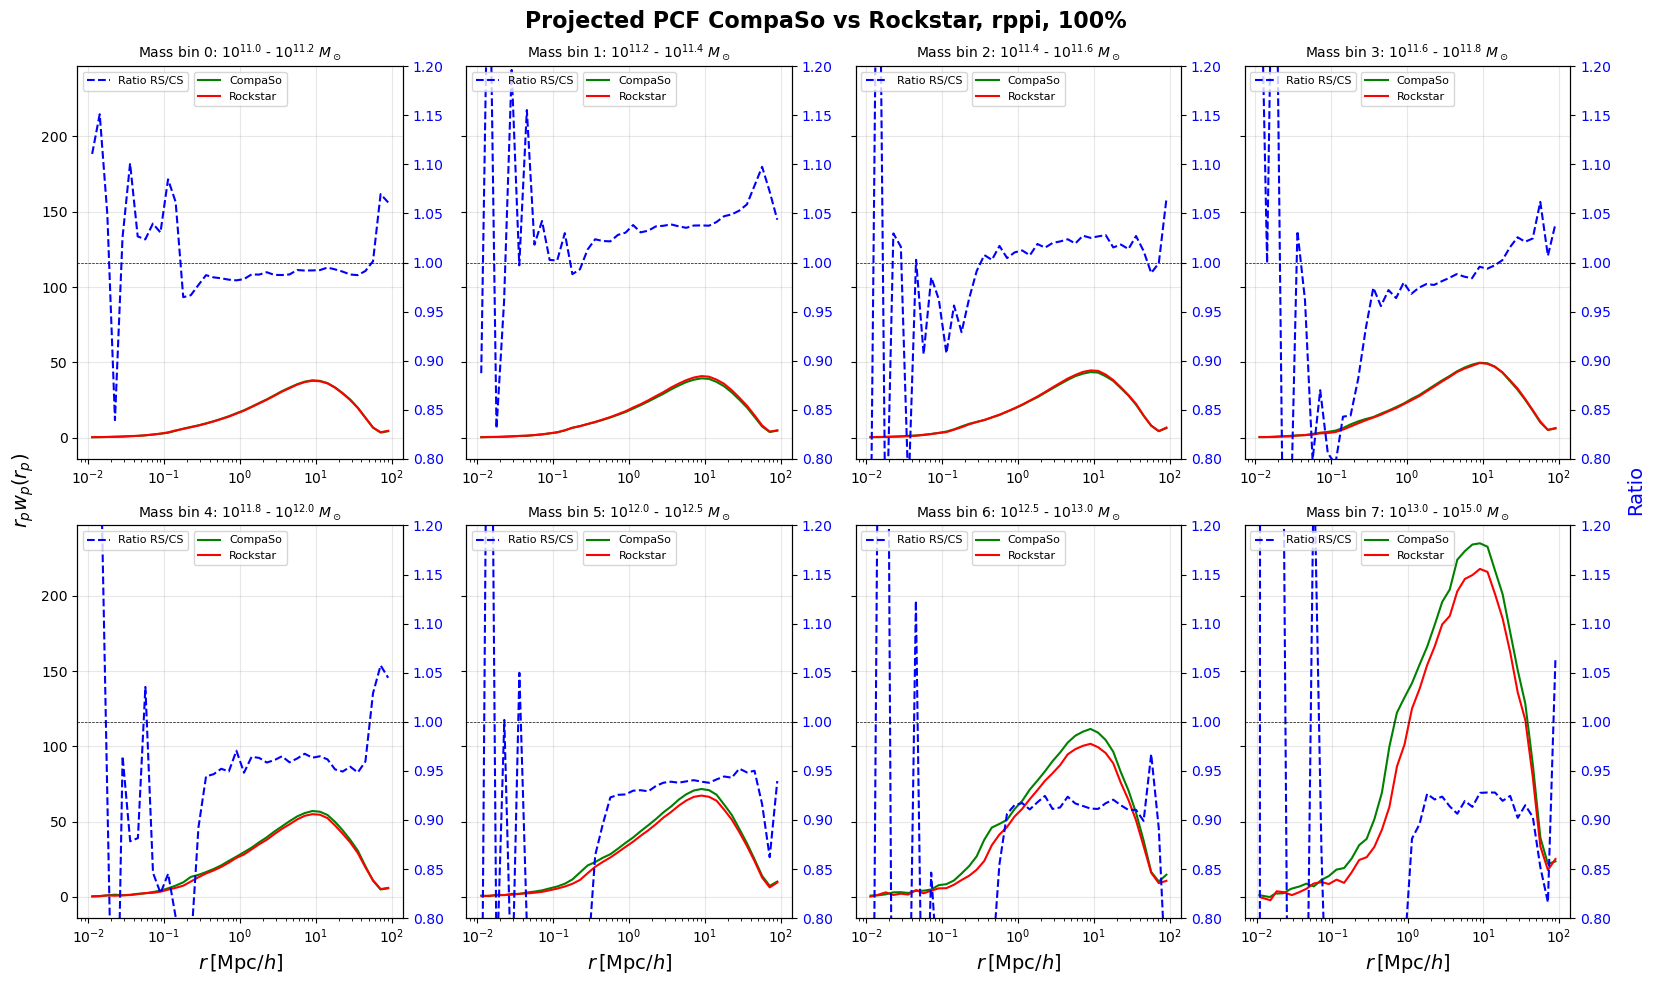

In [69]:
plot_mass_ratio_comparison(
    r_hh_all_cs=rp_all_cs, quantity_all_cs=wp_all_cs, errors_cs = False,
    r_hh_all_rs=rp_all_rs, quantity_all_rs=wp_all_rs, errors_rs = False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title="Projected PCF CompaSo vs Rockstar, rppi, 100%",
    rows=2,
    apply_transformation=lambda r, q: r * q.squeeze(),
    scalex='log',
    scaley=None, ratio_yrange=(0.8,1.2), ratio_leg='upper left', leg_pos='upper center'
)

In [70]:
# ## RSD

# x_cs_all, y_cs_all, z_cs_all = positions_cs_all[:, 0], positions_cs_all[:, 1], positions_cs_all[:, 2]
# x_rs_all, y_rs_all, z_rs_all = positions_RS[:, 0], positions_RS[:, 1], positions_RS[:, 2]

# velocities_all_cs =  np.array(hcat_filtered['v_L2com'])
# z_rsd_all_cs, delta_z_all_cs = rsd_effect(a_cs, positions_cs_all, velocities_all_cs, Hz_cs, name='CompaSO')
# z_rsd_all_rs, delta_z_all_rs = rsd_effect(a_rs, positions_RS, velocities_RS, Hz_cs, name='Rockstar' )

# positions_cs_rsd = np.vstack((x_cs_all, y_cs_all, z_rsd_all_cs)).T
# positions_rs_rsd = np.vstack((x_rs_all, y_rs_all, z_rsd_all_rs)).T

# wp_all_cs_rsd, rp_all_cs_rsd = xi_wrt_mass(mass_bins, Mhalos_filtered_CS, positions_cs_rsd, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_cs_rsd_pid.npz", mask_range=(None, None), nthreads=32)

# wp_all_rs_rsd, rp_all_rs_rsd = xi_wrt_mass(mass_bins, Mhalos_filtered_RS, positions_rs_rsd, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_rs_rsd_pid.npz", mask_range=(None, None), nthreads=32)

In [71]:
# np.savez('/pscratch/sd/g/guittonm/positions_rpwp_rsd_pid.npz', 
#          positions_cs_rsd=positions_cs_rsd,
#          positions_rs_rsd=positions_rs_rsd)    
 
rpwp_rsd = np.load('/pscratch/sd/g/guittonm/positions_rpwp_rsd_pid.npz', allow_pickle=True)
 
positions_cs_rsd = rpwp_rsd['positions_cs_rsd'] 
positions_rs_rsd = rpwp_rsd['positions_rs_rsd'] 

x_cs_all = positions_cs_rsd[:, 0]
y_cs_all = positions_cs_rsd[:, 1]
z_rsd_all_cs = positions_cs_rsd[:, 2]

x_rs_all = positions_rs_rsd[:, 0]
y_rs_all = positions_rs_rsd[:, 1]
z_rsd_all_rs = positions_rs_rsd[:, 2]

In [72]:
# Charger le fichier _pid.npz
data_cs_rppi_rsd = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_cs_rsd_pid.npz")
data_rs_rppi_rsd = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_rs_rsd_pid.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_rppi_rsd.files)
print(data_rs_rppi_rsd.files)

# Extraire les données
mass_bins_cs_rppi_rsd = data_cs_rppi_rsd["mass_bins"]  # Bins de masse
rp_all_cs_rsd = data_cs_rppi_rsd["rp_all"] 
wp_all_cs_rsd = data_cs_rppi_rsd["wp_all"] 

mass_bins_rs_rppi_rsd = data_rs_rppi_rsd["mass_bins"]  # Bins de masse
rp_all_rs_rsd = data_rs_rppi_rsd["rp_all"]  
wp_all_rs_rsd = data_rs_rppi_rsd["wp_all"]

['mass_bins', 'rp_all', 'wp_all']
['mass_bins', 'rp_all', 'wp_all']


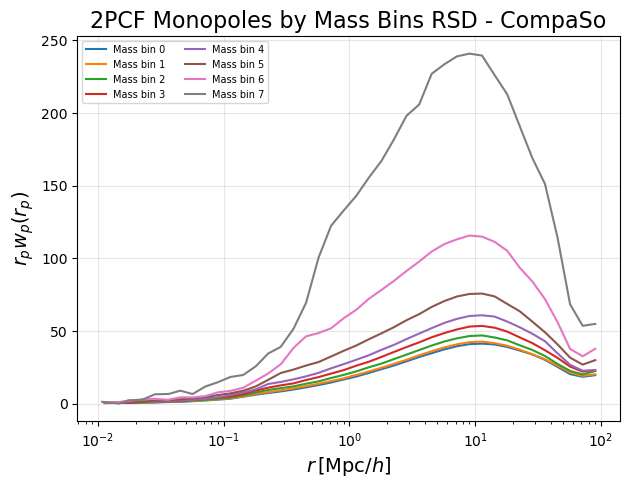

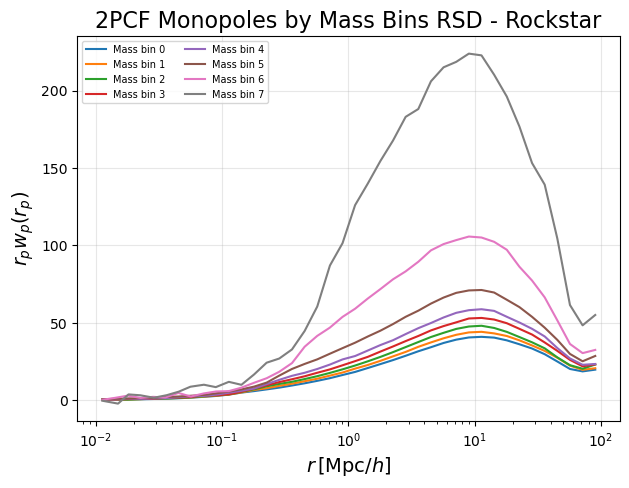

In [73]:
plot_mass_binned_quantity(
    r_hh_all=rp_all_cs_rsd, 
    quantity_all=wp_all_cs_rsd,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins RSD - CompaSo',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

plot_mass_binned_quantity(
    r_hh_all=rp_all_rs_rsd, 
    quantity_all=wp_all_rs_rsd,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins RSD - Rockstar',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

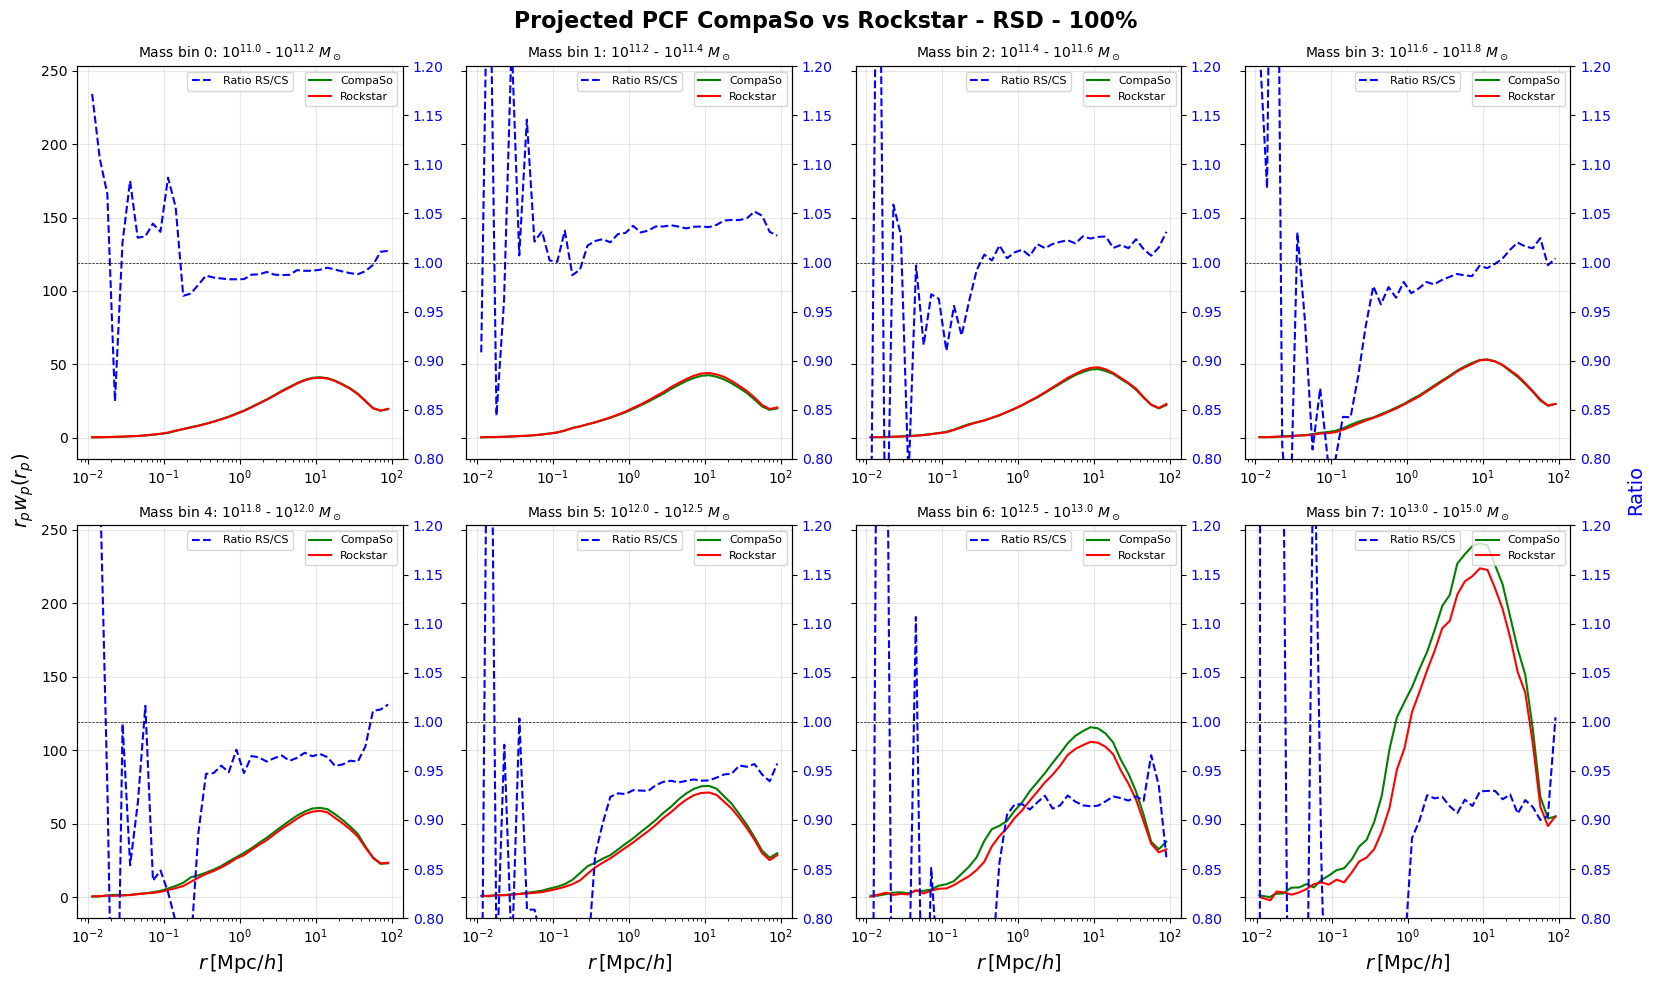

In [74]:
plot_mass_ratio_comparison(
    r_hh_all_cs=rp_all_cs_rsd, quantity_all_cs=wp_all_cs_rsd, errors_cs = False,
    r_hh_all_rs=rp_all_rs_rsd, quantity_all_rs=wp_all_rs_rsd, errors_rs = False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title="Projected PCF CompaSo vs Rockstar - RSD - 100%",
    rows=2,
    apply_transformation=lambda r, q: r * q.squeeze(),
    scalex='log', ratio_yrange=(0.8,1.2),
    scaley=None, leg_pos='upper right', ratio_leg='upper center'
)

### Bootstrap

In [75]:
# print('CompaSo')
# bias_mono_cs_bs, bias_quad_cs_bs = bootstrap_bias_wrt_mass(mass_bins, sampled_masses_cs, positions_cs, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs.npz")
# print('\n', 'Rockstar')
# bias_mono_rs_bs, bias_quad_rs_bs = bootstrap_bias_wrt_mass(mass_bins, sampled_masses_rs, sampled_positions_rs, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_pid.npz")

In [76]:
# Charger le fichier _pid.npz
data_cs_bs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs.npz")
data_rs_bs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_pid.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_bs.files)
print(data_rs_bs.files)
 
## CompaSo 
mass_bins_cs_bs = data_cs_bs["mass_bins"]  # Bins de masse 
r_hh_all_cs_bs = data_cs_bs["r_hh_all"]  # Valeurs de r pour chaque bin
  
xi_hh_mono_all_cs_bs = data_cs_bs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin 
xi_hh_quad_all_cs_bs = data_cs_bs["xi_hh_quad_all"]

bias_by_r_mono_all_cs_bs = data_cs_bs["bias_by_r_mono_all"]
bias_by_r_quad_all_cs_bs = data_cs_bs["bias_by_r_quad_all"] 

mean_bias_mono_all_cs_bs =  data_cs_bs["mean_bias_mono_all"]
mean_bias_quad_all_cs_bs =  data_cs_bs["mean_bias_mono_all"]  

## Rockstar 

mass_bins_rs_bs = data_rs_bs["mass_bins"]  # Bins de masse
r_hh_all_rs_bs = data_rs_bs["r_hh_all"]  # Valeurs de r pour chaque bin
 
xi_hh_mono_all_rs_bs = data_rs_bs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin 
xi_hh_quad_all_rs_bs = data_rs_bs["xi_hh_quad_all"]

bias_by_r_mono_all_rs_bs = data_rs_bs["bias_by_r_mono_all"]
bias_by_r_quad_all_rs_bs = data_rs_bs["bias_by_r_quad_all"]

mean_bias_mono_all_rs_bs =  data_rs_bs["mean_bias_mono_all"]
mean_bias_quad_all_rs_bs =  data_rs_bs["mean_bias_mono_all"]

['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']
['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']


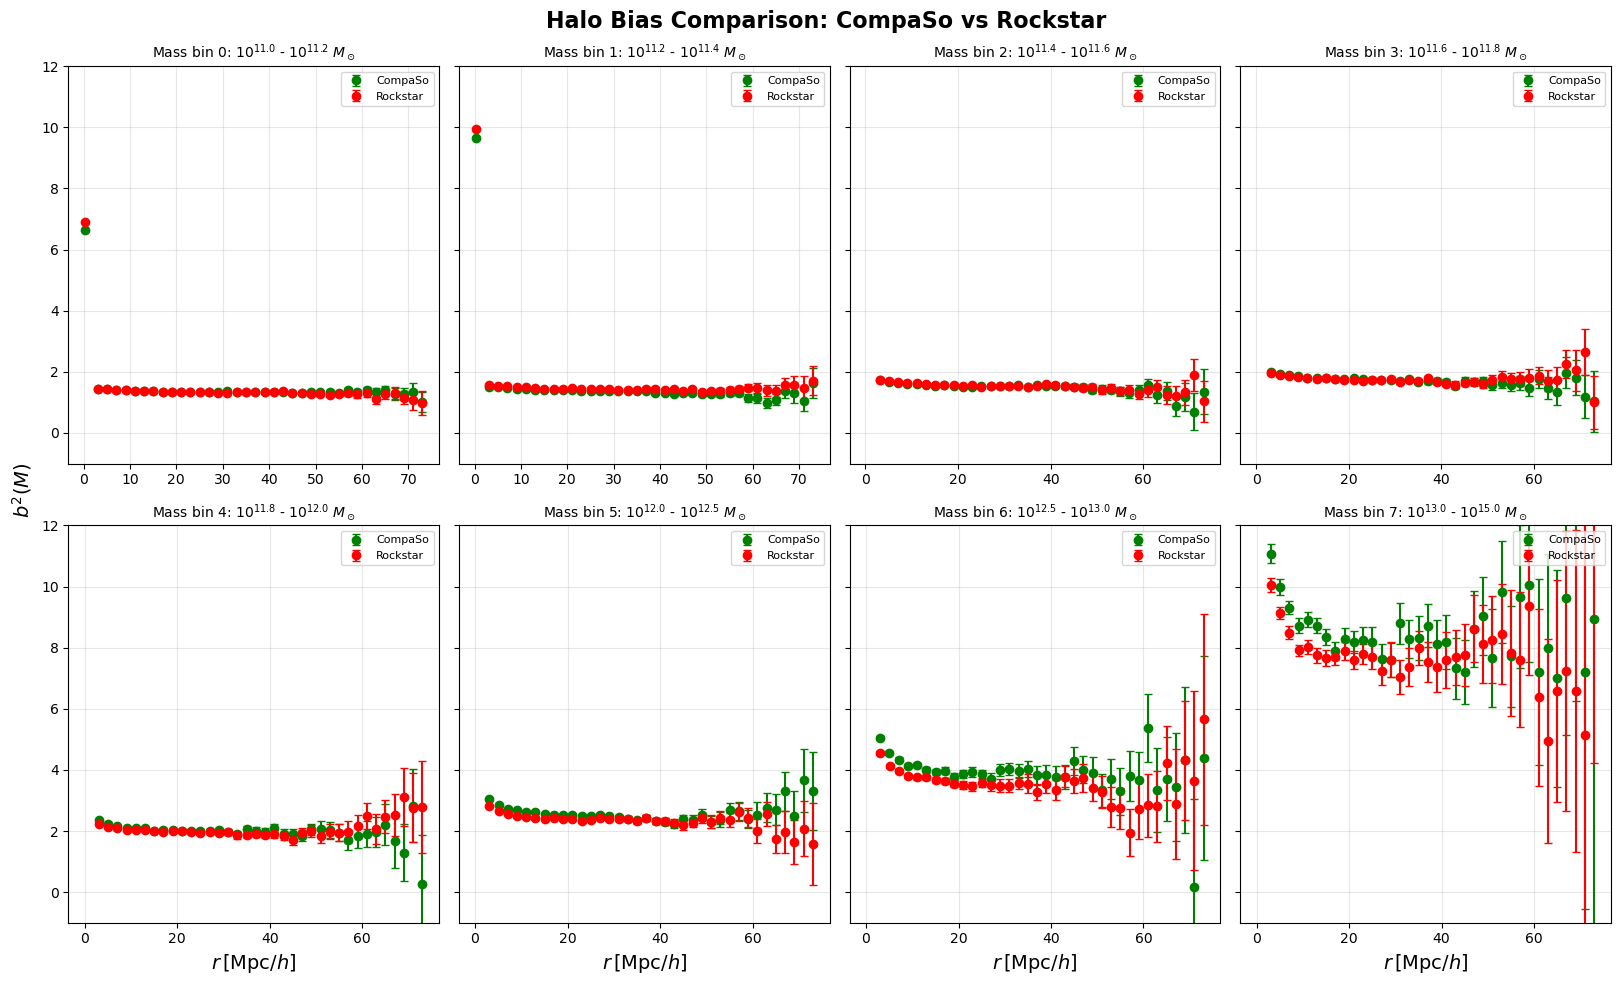

In [77]:
plot_mass_comparison(
    r_hh_all_cs=r_hh_all_cs_bs, quantity_all_cs=mean_bias_mono_all_cs_bs, errors_cs = True,
    r_hh_all_rs=r_hh_all_rs_bs, quantity_all_rs=mean_bias_mono_all_rs_bs, errors_rs = True,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2,
    yrange = (-1, 12),
    mask_range=(0,75),
    scalex=None,
    scaley=None
)

In [78]:
n_bins = len(mass_bins) - 1

bias_values_cs = np.array([np.mean(mean_bias_mono_all_cs_bs[i][0]) for i in range(n_bins)])
bias_errors_cs = np.array([np.mean(mean_bias_mono_all_cs_bs[i][1]) for i in range(n_bins)])

bias_values_rs = np.array([np.mean(mean_bias_mono_all_rs_bs[i][0]) for i in range(n_bins)])
bias_errors_rs = np.array([np.mean(mean_bias_mono_all_rs_bs[i][1]) for i in range(n_bins)])

# Milieu des bins de masse
bias_masses_cs = 0.5 * (mass_bins[:-1] + mass_bins[1:])
bias_masses_rs = 0.5 * (mass_bins[:-1] + mass_bins[1:])

In [79]:
plot_masses_fct(data_list = [bias_values_cs, bias_values_rs],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-', '-'],
                ylabel = r'$b^2(M)$', 
                title = "Halo Bias vs Mass with Bootstrap Uncertainty",
                scale = 'semilogx',
                errors_list = [bias_errors_cs, bias_errors_rs])

NameError: name 'mass_centers_cs' is not defined

### Bootstrap removing

In [97]:
# print('CompaSo')
# bias_mono_cs_bs_rm, bias_quad_cs_bs_rm = removing_bias_wrt_mass(mass_bins, sampled_masses_cs, positions_cs, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs_rm.npz")
# print('\n', 'Rockstar')
# bias_mono_rs_bs_rm, bias_quad_rs_bs_rm = removing_bias_wrt_mass(mass_bins, sampled_masses_rs, sampled_positions_rs, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_rm_pid.npz")

In [98]:
# Charger le fichier _pid.npz 
data_cs_bs_rm = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs_rm.npz")
data_rs_bs_rm = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_rm_pid.npz") 
 
# Afficher les clés du fichier pour voir ce qu'il contient 
print(data_cs_bs_rm.files) 
print(data_rs_bs_rm.files)

## CompaSo
mass_bins_cs_bs_rm = data_cs_bs_rm["mass_bins"]  # Bins de masse
r_hh_all_cs_bs_rm = data_cs_bs_rm["r_hh_all"]  # Valeurs de r pour chaque bin 
 
xi_hh_mono_all_cs_bs_rm = data_cs_bs_rm["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin 
xi_hh_quad_all_cs_bs_rm = data_cs_bs_rm["xi_hh_quad_all"]

bias_by_r_mono_all_cs_bs_rm = data_cs_bs_rm["bias_by_r_mono_all"]
bias_by_r_quad_all_cs_bs_rm = data_cs_bs_rm["bias_by_r_quad_all"]
 
mean_bias_mono_all_cs_bs_rm =  data_cs_bs_rm["mean_bias_mono_all"]
mean_bias_quad_all_cs_bs_rm =  data_cs_bs_rm["mean_bias_mono_all"]

## Rockstar
 
mass_bins_rs_bs_rm = data_rs_bs_rm["mass_bins"]  # Bins de masse 
r_hh_all_rs_bs_rm = data_rs_bs_rm["r_hh_all"]  # Valeurs de r pour chaque bin 

xi_hh_mono_all_rs_bs_rm = data_rs_bs_rm["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
xi_hh_quad_all_rs_bs_rm = data_rs_bs_rm["xi_hh_quad_all"]

bias_by_r_mono_all_rs_bs_rm = data_rs_bs_rm["bias_by_r_mono_all"]
bias_by_r_quad_all_rs_bs_rm = data_rs_bs_rm["bias_by_r_quad_all"]

mean_bias_mono_all_rs_bs_rm =  data_rs_bs_rm["mean_bias_mono_all"]
mean_bias_quad_all_rs_bs_rm =  data_rs_bs_rm["mean_bias_mono_all"]

['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']
['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']


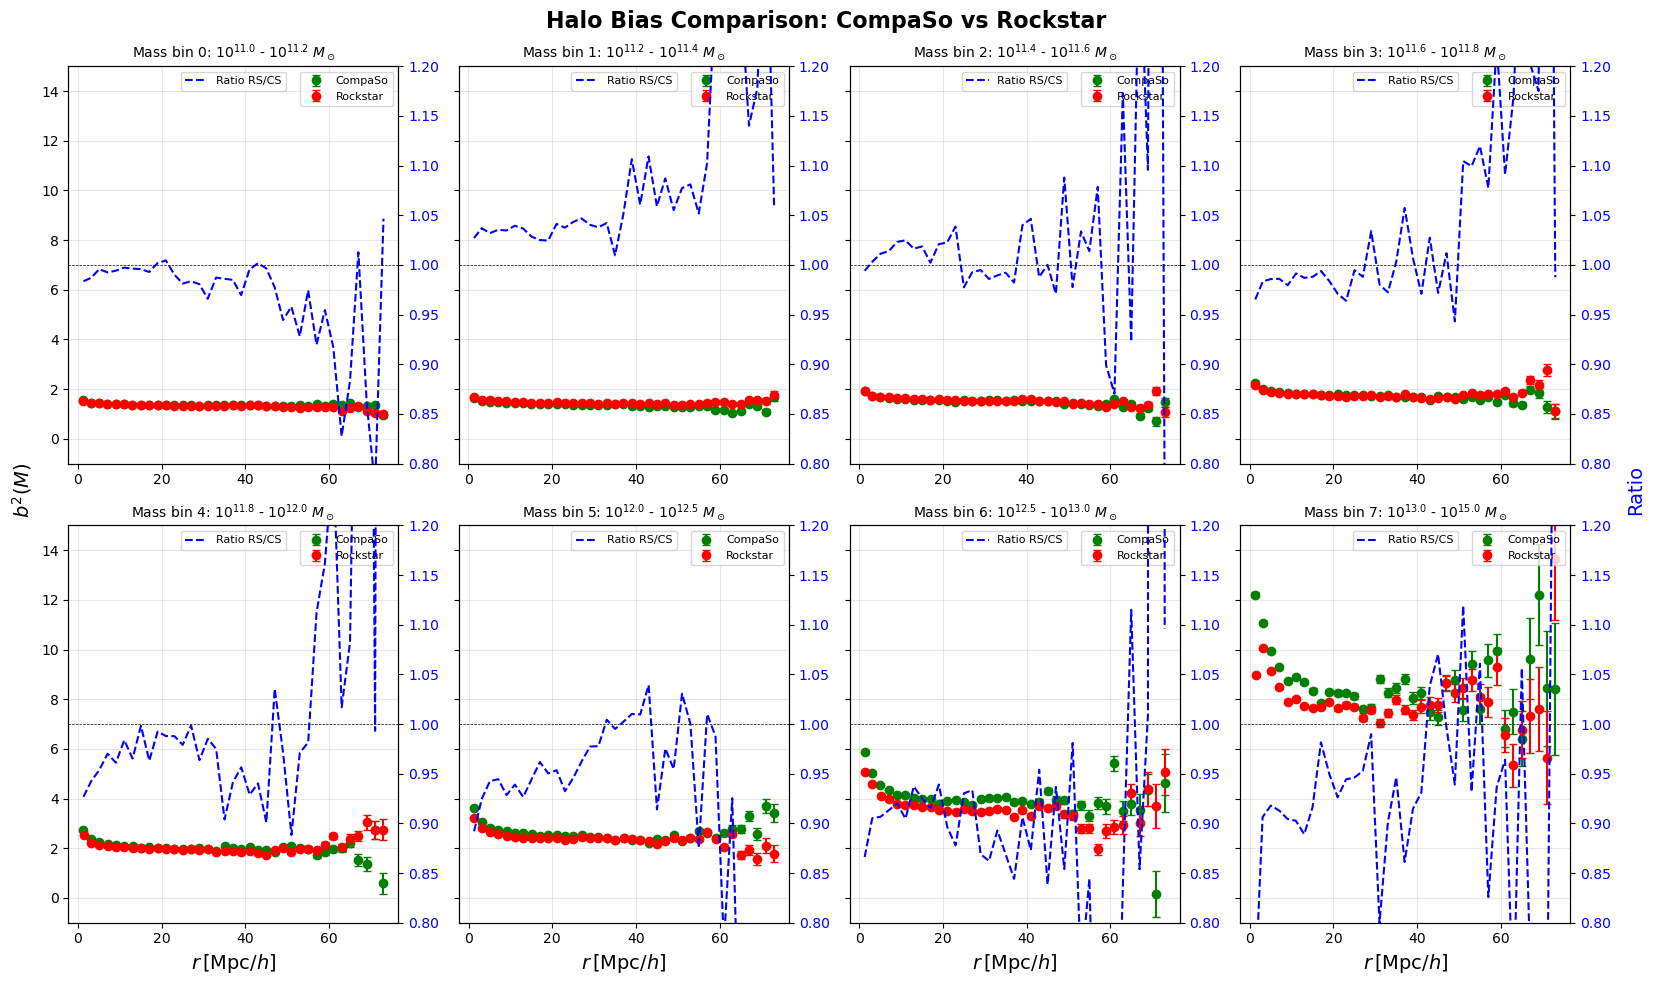

In [99]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs_bs_rm, quantity_all_cs=mean_bias_mono_all_cs_bs_rm, errors_cs = True,
    r_hh_all_rs=r_hh_all_rs_bs_rm, quantity_all_rs=mean_bias_mono_all_rs_bs_rm, errors_rs = True,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2,
    yrange = (-1, 15), ratio_yrange=(0.8,1.2),
    mask_range=(0,75),
    scalex=None,
    scaley=None, leg_pos='upper right', ratio_leg='upper center'
)

In [100]:
n_bins = len(mass_bins) - 1

bias_values_cs_rm = np.array([np.mean(mean_bias_mono_all_cs_bs_rm[i][0]) for i in range(n_bins)])
bias_errors_cs_rm = np.array([np.mean(mean_bias_mono_all_cs_bs_rm[i][1]) for i in range(n_bins)])

bias_values_rs_rm = np.array([np.mean(mean_bias_mono_all_rs_bs_rm[i][0]) for i in range(n_bins)])
bias_errors_rs_rm = np.array([np.mean(mean_bias_mono_all_rs_bs_rm[i][1]) for i in range(n_bins)])

# Milieu des bins de masse
bias_masses_cs_rm = 0.5 * (mass_bins[:-1] + mass_bins[1:])
bias_masses_rs_rm = 0.5 * (mass_bins[:-1] + mass_bins[1:])

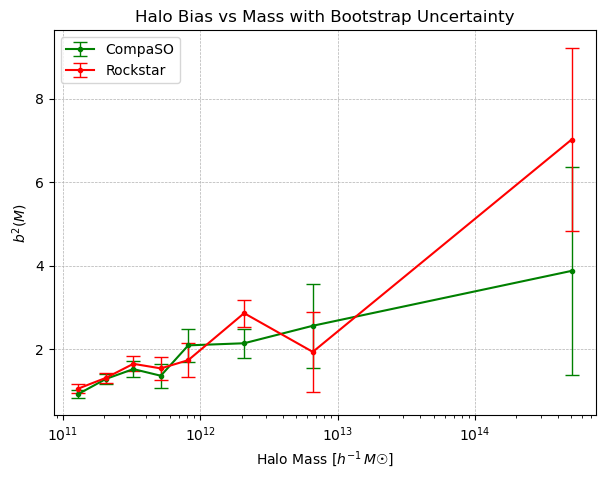

In [101]:
plot_masses_fct(data_list = [bias_values_cs_rm, bias_values_rs_rm],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-', '-'],
                ylabel = r'$b^2(M)$', 
                title = "Halo Bias vs Mass with Bootstrap Uncertainty",
                scale = 'semilogx',
                errors_list = [bias_errors_cs_rm, bias_errors_rs_rm])

# Trash

### Monopole

In [96]:
# # Bias calculation
# bias_mono_cs = (xi_cs_mono / xi_mm_mono).squeeze()
# bias_mono_rs = (xi_rs_mono / xi_mm_mono).squeeze()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_mono, bias_mono_cs,  marker='o', color='green', label='CompaSo - 10% halos', markersize=4)
# plt.semilogx(r_rs_mono, bias_mono_rs,  marker='o', color='red', label ='Rockstar - 10% halos', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b^2(M)$', fontsize=14)
# plt.title('Halos bias, monopole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_mono, bias_mono_rs / bias_mono_cs,  marker='o', color='blue', label='Rockstar - CompaSo', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b^2_{\mathrm{RS}} \,/\, b^2_{\mathrm{CS}}$', fontsize=14)
# plt.title('Halos bias ratio, monopole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

In [97]:
# def plot_bias_filtered(r_cs, bias_cs, r_rs, bias_rs, title, r_min=40, r_max=80):

#     mask_cs = (r_cs >= r_min) & (r_cs <= r_max)
#     mask_rs = (r_rs >= r_min) & (r_rs <= r_max)

#     r_cs_filtered, bias_cs_filtered = r_cs[mask_cs], bias_cs[mask_cs]
#     r_rs_filtered, bias_rs_filtered = r_rs[mask_rs], bias_rs[mask_rs]

#     # Calcul de la différence Rockstar - CompaSO
#     bias_ratio = bias_rs_filtered / bias_cs_filtered

#     # Tracé du biais des halos
#     plt.figure(figsize=(7, 5))
#     plt.semilogx(r_cs_filtered, bias_cs_filtered, marker='o', color='green', label='CompaSO', markersize=4)
#     plt.semilogx(r_rs_filtered, bias_rs_filtered, marker='o', color='red', label='Rockstar', markersize=4)
#     plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
#     plt.ylabel(r'$b^2(M)$', fontsize=14)  
#     plt.title(f'Halos bias, {title}', fontsize=14)
#     plt.grid(True, alpha=0.3)
#     ax = plt.gca()  # Récupère l'axe actuel
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Met un tick tous les 10 Mpc/h
#     ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))  # Affichage normal (40, 50...)
#     plt.legend(loc='best')
#     plt.show()

#     # Tracé de la différence Rockstar - CompaSO
#     plt.figure(figsize=(7, 5))
#     plt.semilogx(r_cs_filtered, bias_ratio, marker='o', color='blue', label='Rockstar - CompaSO', markersize=4)
#     plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
#     plt.ylabel(r'$b^2_{\mathrm{RS}} \,/\, b^2_{\mathrm{CS}}$', fontsize=14)
#     plt.title(f'Halos bias difference, {title}', fontsize=14)
#     plt.grid(True, alpha=0.3)
#     ax = plt.gca()  # Récupère l'axe actuel
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Met un tick tous les 10 Mpc/h
#     ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))  # Affichage normal (40, 50...)
#     plt.legend(loc='best')
#     plt.show()

In [98]:
# plot_bias_filtered(r_cs_mono, bias_mono_cs, r_rs_mono, bias_mono_rs, title='monopole')

### Quadrupole

In [99]:
# # Bias calculation
# bias_quad_cs = (xi_cs_quad / xi_mm_quad).squeeze()
# bias_quad_rs = (xi_rs_quad / xi_mm_quad).squeeze()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_quad, bias_quad_cs,  marker='o', color='green', label='CompaSo', markersize=4)
# plt.semilogx(r_rs_quad, bias_quad_rs,  marker='o', color='red', label ='Rockstar', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b(r)$', fontsize=14)
# plt.title('Halos bias, quadrupole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_quad, bias_quad_rs - bias_quad_cs,  marker='o', color='blue', label='Rockstar - CompaSo', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b(r)$', fontsize=14)
# plt.title('Halos bias difference, quadrupole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

In [100]:
# plot_bias_filtered(r_cs_quad, bias_quad_cs, r_rs_quad, bias_quad_rs, title='quadrupole')

# RSD SMU

In [102]:
# ## CompaSo

# results_smu_cs_rsd = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_cs,
#     los='z'
# )

In [40]:
from pycorr import setup_logging

In [41]:
setup_logging()

In [51]:
## Rockstar

results_smu_rs_rsd = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
    data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
    nthreads=256,
    boxsize=boxsize_rs, 
    los='z'
) 

[000020.86]  04-15 06:40  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000020.86]  04-15 06:40  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000020.86]  04-15 06:40  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.


: 

In [104]:
# ## CompaSo

# results_smu_cs_rsd = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Bornes des distances pour les bins 
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_cs,
#     los='z'
# )

# ## Rockstar

# results_smu_rs_rsd = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_rs, 
#     los='z'
# ) 

In [105]:
# ## CompaSo

# results_smu_cs_rsd_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_cs,
#     los='z'
# )

# ## Rockstar

# results_smu_rs_rsd_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_rs, 
#     los='z'
# )  

In [33]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs_rsd_all.npz',  
#          results_smu_cs_rsd=results_smu_cs_rsd)    
   
data_smu_cs_rsd_all = np.load('/pscratch/sd/g/guittonm/smu_cs_rsd_all.npz', allow_pickle=True)
  
results_smu_cs_rsd = data_smu_cs_rsd_all['results_smu_cs_rsd'].item()  
 
# np.savez('/pscratch/sd/g/guittonm/smu_rs_rsd_pid.npz', 
#          results_smu_rs_rsd=results_smu_rs_rsd)   
 
# data_smu_rs_rsd = np.load('/pscratch/sd/g/guittonm/smu_rs_rsd_pid.npz', allow_pickle=True)
 
# results_smu_rs_rsd = data_smu_rs_rsd['results_smu_rs_rsd'].item()  

In [107]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs_rsd.npz',  
#          results_smu_cs_rsd=results_smu_cs_rsd)    
   
data_smu_cs_rsd = np.load('/pscratch/sd/g/guittonm/smu_cs_rsd.npz', allow_pickle=True)
  
results_smu_cs_rsd = data_smu_cs_rsd['results_smu_cs_rsd'].item()  
 
# np.savez('/pscratch/sd/g/guittonm/smu_rs_rsd_pid.npz', 
#          results_smu_rs_rsd=results_smu_rs_rsd)   
 
data_smu_rs_rsd = np.load('/pscratch/sd/g/guittonm/smu_rs_rsd_pid.npz', allow_pickle=True)
 
results_smu_rs_rsd = data_smu_rs_rsd['results_smu_rs_rsd'].item()

In [80]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs_rsd_log.npz',  
#          results_smu_cs_rsd_log=results_smu_cs_rsd_log)    
   
data_smu_cs_rsd_log = np.load('/pscratch/sd/g/guittonm/smu_cs_rsd_log.npz', allow_pickle=True)
  
results_smu_cs_rsd_log = data_smu_cs_rsd_log['results_smu_cs_rsd_log'].item()  
 
# np.savez('/pscratch/sd/g/guittonm/smu_rs_rsd_log_pid.npz', 
#          results_smu_rs_rsd_log=results_smu_rs_rsd_log)   
 
data_smu_rs_rsd_log = np.load('/pscratch/sd/g/guittonm/smu_rs_rsd_log_pid.npz', allow_pickle=True)
 
results_smu_rs_rsd_log = data_smu_rs_rsd_log['results_smu_rs_rsd_log'].item()

In [81]:
r_cs_mono, xi_cs_mono = results_smu_cs(ells=(0,), return_sep=True)
r_rs_mono, xi_rs_mono = results_smu_rs(ells=(0,), return_sep=True)


r_cs_mono_log, xi_cs_mono_log = results_smu_cs_log(ells=(0,), return_sep=True)
r_rs_mono_log, xi_rs_mono_log = results_smu_rs_log(ells=(0,), return_sep=True)

In [82]:
r_cs_mono_rsd, xi_cs_mono_rsd = results_smu_cs_rsd(ells=(0,), return_sep=True)
r_rs_mono_rsd, xi_rs_mono_rsd = results_smu_rs_rsd(ells=(0,), return_sep=True)

r_cs_mono_rsd_log, xi_cs_mono_rsd_log = results_smu_cs_rsd_log(ells=(0,), return_sep=True)
r_rs_mono_rsd_log, xi_rs_mono_rsd_log = results_smu_rs_rsd_log(ells=(0,), return_sep=True)

NameError: name 'results_smu_cs_rsd' is not defined

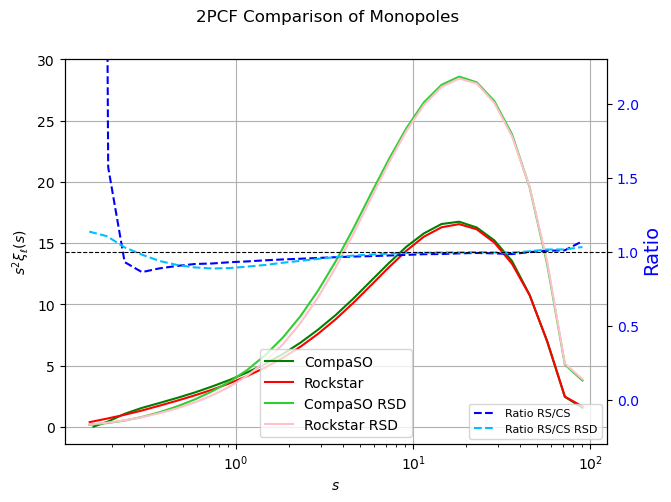

In [111]:
print_chosen_multipole_ratio(
    [r_cs_mono_log, r_rs_mono_log, r_cs_mono_rsd_log, r_rs_mono_rsd_log], 
    [xi_cs_mono_log, xi_rs_mono_log, xi_cs_mono_rsd_log, xi_rs_mono_rsd_log], [[1,0],[3,2]], 
    ["CompaSO", "Rockstar", "CompaSO RSD", "Rockstar RSD"], ratio_legends=['Ratio RS/CS', 'Ratio RS/CS RSD'],
    title="Monopoles",
    colors_list = ['green', 'red', 'limegreen', 'pink'], ratio_colors=['blue', 'deepskyblue'],
    ratio_yrange=(-0.3, 2.3), scalex='log', leg_loc='lower center', ratio_leg_loc='lower right'
)

In [112]:
r_cs_quad_log, xi_cs_quad_log = results_smu_cs_log(ells=(2,), return_sep=True)
r_rs_quad_log, xi_rs_quad_log = results_smu_rs_log(ells=(2,), return_sep=True)

r_cs_quad_rsd, xi_cs_quad_rsd = results_smu_cs_rsd(ells=(2,), return_sep=True)
r_rs_quad_rsd, xi_rs_quad_rsd = results_smu_rs_rsd(ells=(2,), return_sep=True)

r_cs_quad_rsd_log, xi_cs_quad_rsd_log = results_smu_cs_rsd_log(ells=(2,), return_sep=True)
r_rs_quad_rsd_log, xi_rs_quad_rsd_log = results_smu_rs_rsd_log(ells=(2,), return_sep=True)

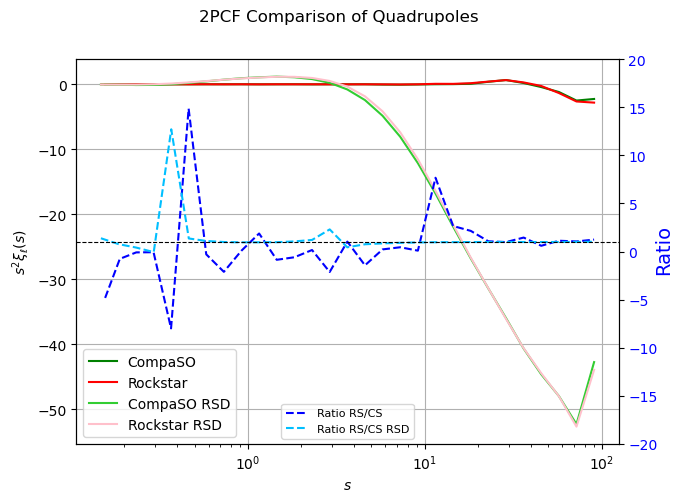

In [113]:
print_chosen_multipole_ratio(
    [r_cs_quad_log, r_rs_quad_log, r_cs_quad_rsd_log, r_rs_quad_rsd_log], 
    [xi_cs_quad_log, xi_rs_quad_log, xi_cs_quad_rsd_log, xi_rs_quad_rsd_log], [[1,0],[3,2]], 
    ["CompaSO", "Rockstar", "CompaSO RSD", "Rockstar RSD"], ratio_legends=['Ratio RS/CS', 'Ratio RS/CS RSD'],
    title="Quadrupoles",
    colors_list = ['green', 'red', 'limegreen', 'pink'], ratio_colors=['blue', 'deepskyblue'], #pink
    ratio_yrange=(-20, 20), scalex='log', ratio_leg_loc='lower center', leg_loc='lower left'
)

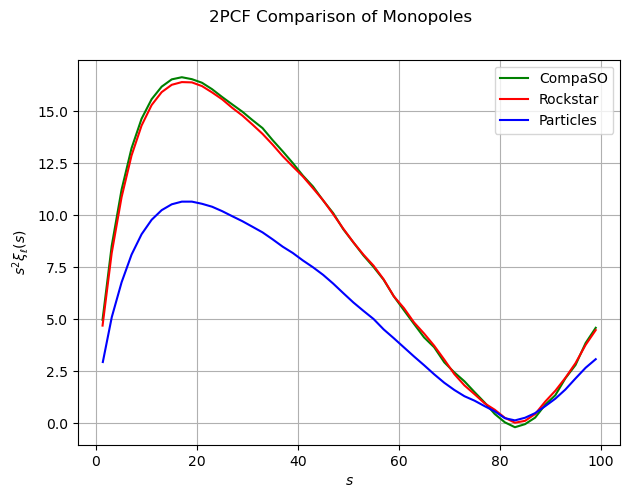

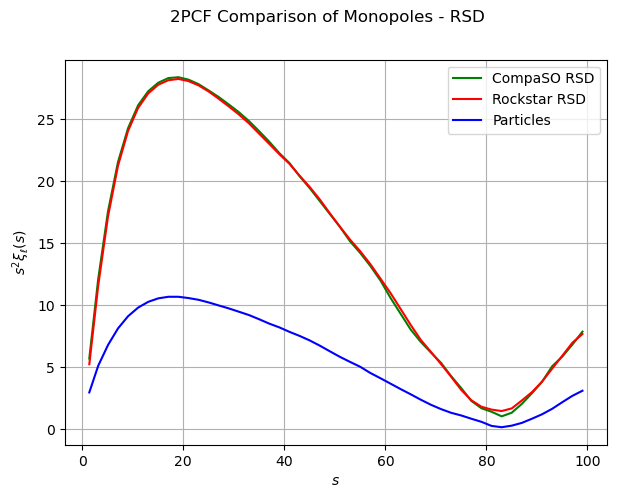

In [114]:
print_chosen_multipole(
    [r_cs_mono, r_rs_mono, r_mm_mono], 
    [xi_cs_mono, xi_rs_mono, xi_mm_mono], 
    ["CompaSO", "Rockstar", "Particles"], 
    "Monopoles",
    colors_list = ['green', 'red', 'blue']
)

print_chosen_multipole(
    [r_cs_mono_rsd, r_rs_mono_rsd, r_mm_mono, r_cs_mono, r_rs_mono,], 
    [xi_cs_mono_rsd, xi_rs_mono_rsd, xi_mm_mono], 
    ["CompaSO RSD", "Rockstar RSD", "Particles"], 
    "Monopoles - RSD",
    colors_list = ['green', 'red', 'blue']
)

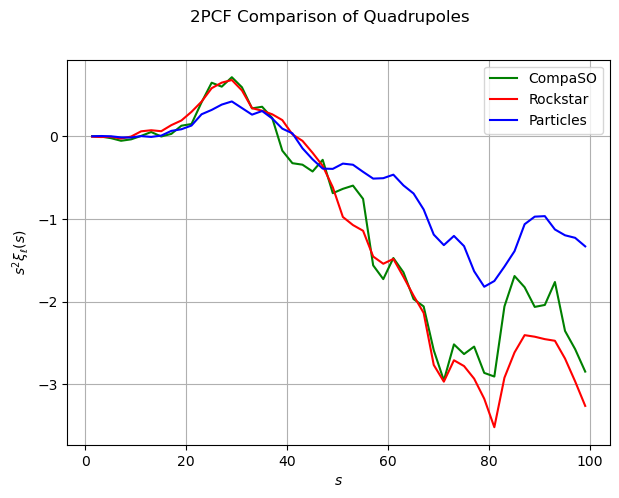

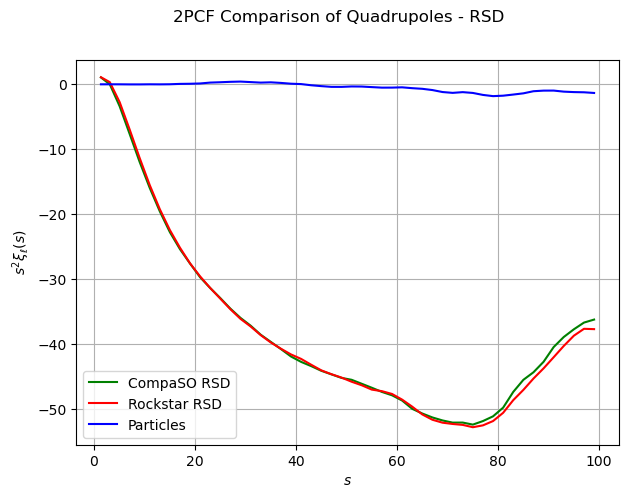

In [115]:
print_chosen_multipole(
    [r_cs_quad, r_rs_quad, r_mm_quad], 
    [xi_cs_quad, xi_rs_quad, xi_mm_quad], 
    ["CompaSO", "Rockstar", "Particles"], 
    "Quadrupoles",
    colors_list = ['green', 'red', 'blue']
)

print_chosen_multipole(
    [r_cs_quad_rsd, r_rs_quad_rsd, r_mm_quad, r_cs_quad, r_rs_quad,], 
    [xi_cs_quad_rsd, xi_rs_quad_rsd, xi_mm_quad], 
    ["CompaSO RSD", "Rockstar RSD", "Particles"], 
    "Quadrupoles - RSD",
    colors_list = ['green', 'red', 'blue']
)

# Xi_gm

In [116]:
# # Delta Sigma

# results_gm_cs = TwoPointCorrelationFunction(
#     mode='smu',
#     edges=(bins_s, bins_mu),
#     data_positions1 = positions_mm_sampled,
#     data_positions2 = (x_cs - boxsize_cs / 2, y_cs - boxsize_cs /2 , z_cs  - boxsize_cs /2),
#     boxsize=boxsize_cs,
#     nthreads=32,
#     los='z'
# ) 

# results_gm_rs = TwoPointCorrelationFunction(
#     mode='smu',
#     edges=(bins_s, bins_mu),
#     data_positions1 = positions_mm_sampled,
#     data_positions2 = (x_rs, y_rs, z_rs),
#     boxsize=boxsize_rs,
#     nthreads=32,
#     los='z'
# )

In [117]:
# s_gm = results_gm_cs.sep  # Distances bin centrées

# r_gm_cs, xi_gm_cs = results_gm_cs(ells=(0,), return_sep=True)
# r_gm_rs, xi_gm_rs = results_gm_rs(ells=(0,), return_sep=True)

# # Enregistrement des résultats 
# np.savez("/pscratch/sd/g/guittonm/results_gm_pid.npz", 
#          results_gm_cs=results_gm_cs,
#          results_gm_rs=results_gm_rs,
#          r_gm_cs=r_gm_cs, 
#          r_gm_rs=r_gm_rs,  
#          xi_gm_cs=xi_gm_cs, 
#          xi_gm_rs=xi_gm_rs)   

In [84]:
# Charger le fichier _pid.npz
data_gm = np.load("/pscratch/sd/g/guittonm/results_gm_pid.npz", allow_pickle=True)

# Afficher les clés du fichier pour voir ce qu'il contient  
print(data_gm.files)

results_gm_cs = data_gm['results_gm_cs'].item()
results_gm_rs = data_gm['results_gm_rs'].item()

r_gm_cs = data_gm['r_gm_cs']
xi_gm_cs = data_gm['xi_gm_cs']

r_gm_rs = data_gm['r_gm_rs']
xi_gm_rs = data_gm['xi_gm_rs']

['results_gm_cs', 'results_gm_rs', 'r_gm_cs', 'r_gm_rs', 'xi_gm_cs', 'xi_gm_rs']


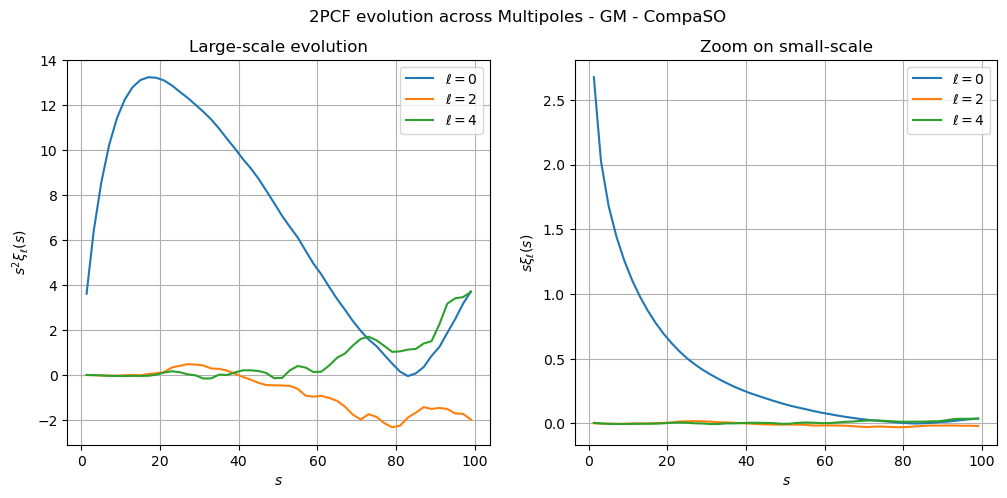

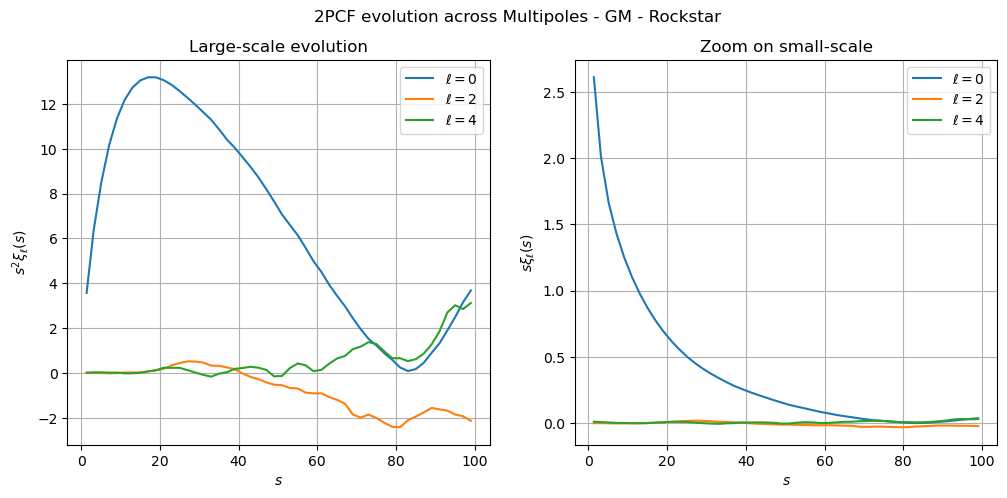

In [85]:
print_multipoles(results_gm_cs, ells, title = 'GM - CompaSO')

print_multipoles(results_gm_rs, ells, title = 'GM - Rockstar')

In [120]:
# xi_gm_cs_per_mass_bin = []
# r_gm_cs_per_mass_bin = []

# for i, (low, high) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
#     mask = (sampled_masses_cs >= low) & (sampled_masses_cs < high)

#     x_ad = x_cs - boxsize_cs / 2
#     y_ad = y_cs - boxsize_cs / 2
#     z_ad = z_cs - boxsize_cs / 2

#     halos_in_bin = np.array([x_ad[mask], y_ad[mask], z_ad[mask]])

#     if halos_in_bin.shape[1] == 0:
#         print(f"Skipping mass bin {i} because it contains no halos.")
#         continue

#     results_gm = TwoPointCorrelationFunction(
#         mode='smu',
#         edges=(bins_s, bins_mu),
#         data_positions1=positions_mm_sampled,
#         data_positions2=halos_in_bin,
#         boxsize=boxsize_cs,
#         nthreads=32,
#         los='z'
#     )

#     r_gm_cs, xi_gm = results_gm(ells=(0,), return_sep=True)  # On récupère juste le monopole
#     xi_gm_cs_per_mass_bin.append(xi_gm)
#     r_gm_cs_per_mass_bin.append(r_gm_cs)

# xi_gm_cs_per_mass_bin = np.array(xi_gm_cs_per_mass_bin)
# r_gm_cs_per_mass_bin = np.array(r_gm_cs_per_mass_bin)

In [121]:
# xi_gm_rs_per_mass_bin = []
# r_gm_rs_per_mass_bin = []

# for i, (low, high) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
#     mask = (sampled_masses_rs >= low) & (sampled_masses_rs < high)

#     halos_in_bin = np.array([x_rs[mask], y_rs[mask], z_rs[mask]])

#     if halos_in_bin.shape[1] == 0:
#         print(f"Skipping mass bin {i} because it contains no halos.")
#         continue

#     results_gm = TwoPointCorrelationFunction(
#         mode='smu',
#         edges=(bins_s, bins_mu),
#         data_positions1=positions_mm_sampled,
#         data_positions2=halos_in_bin,
#         boxsize=boxsize_rs,
#         nthreads=32,
#         los='z'
#     )

#     r_gm_rs, xi_gm = results_gm(ells=(0,), return_sep=True)  # On récupère juste le monopole
#     xi_gm_rs_per_mass_bin.append(xi_gm)
#     r_gm_rs_per_mass_bin.append(r_gm_rs)

# xi_gm_rs_per_mass_bin = np.array(xi_gm_rs_per_mass_bin)
# r_gm_rs_per_mass_bin = np.array(r_gm_rs_per_mass_bin)

In [86]:
# np.savez('/pscratch/sd/g/guittonm/results_gm_per_mass_bin_cs_pid.npz', 
#             mass_bins=mass_bins, 
#             xi_gm_cs_per_mass_bin=xi_gm_cs_per_mass_bin, 
#             r_gm_cs_per_mass_bin=r_gm_cs_per_mass_bin) #             rppi_pi_all=rppi_pi_all, 

# print(f"\n Fichier enregistré")

# np.savez('/pscratch/sd/g/guittonm/results_gm_per_mass_bin_rs_pid.npz', 
#             mass_bins=mass_bins, 
#             xi_gm_rs_per_mass_bin=xi_gm_rs_per_mass_bin, 
#             r_gm_rs_per_mass_bin=r_gm_rs_per_mass_bin)          

data_cs_gm = np.load("/pscratch/sd/g/guittonm/results_gm_per_mass_bin_cs_pid.npz")
data_rs_gm = np.load("/pscratch/sd/g/guittonm/results_gm_per_mass_bin_rs_pid.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_gm.files)
print(data_rs_gm.files)

# Extraire les données
xi_gm_cs_per_mass_bin = data_cs_gm["xi_gm_cs_per_mass_bin"] 
r_gm_cs_per_mass_bin = data_cs_gm["r_gm_cs_per_mass_bin"] 

xi_gm_rs_per_mass_bin = data_rs_gm["xi_gm_rs_per_mass_bin"] 
r_gm_rs_per_mass_bin = data_rs_gm["r_gm_rs_per_mass_bin"] 

print(xi_gm_rs_per_mass_bin.shape)
print(r_gm_rs_per_mass_bin.shape)

['mass_bins', 'xi_gm_cs_per_mass_bin', 'r_gm_cs_per_mass_bin']
['mass_bins', 'xi_gm_rs_per_mass_bin', 'r_gm_rs_per_mass_bin']
(8, 1, 50)
(8, 50)


In [87]:
mass_bin_centers = np.sqrt(mass_bins[:-1] * mass_bins[1:])

shape: (50,)
[False False False  True  True  True  True  True]
[False False False False False  True  True  True]
[False False False False False False  True  True]
[False False False False False False False  True]


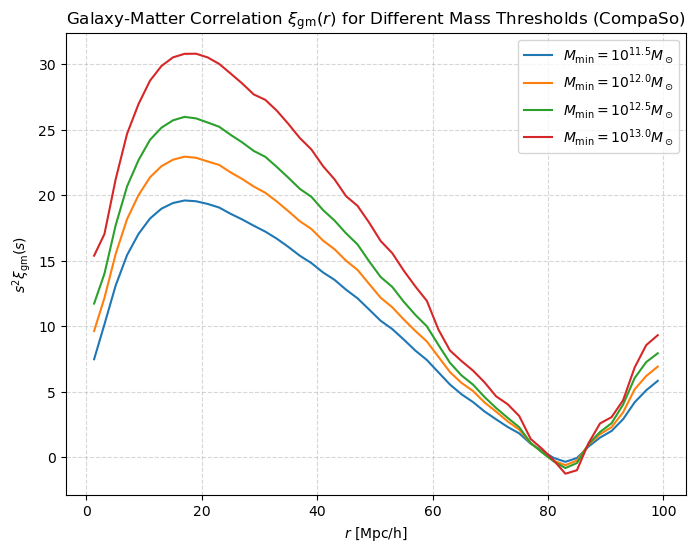

shape: (50,)
[False False False  True  True  True  True  True]
[False False False False False  True  True  True]
[False False False False False False  True  True]
[False False False False False False False  True]


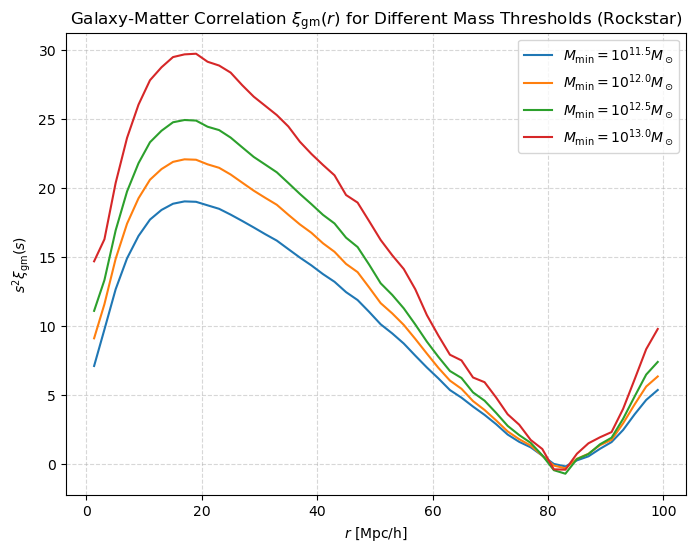

In [88]:
def plot_xigm_vs_mass(mass_bins, xi_gm_all, r_values, mass_thresholds, title):
    mass_bin_centers = np.sqrt(mass_bins[:-1] * mass_bins[1:])

    plt.figure(figsize=(8,6))

    r_values=r_values[0]
    print('shape:', r_values.shape)
    for mass_threshold in mass_thresholds:
        mask = mass_bin_centers > mass_threshold
        print(mask)
        if np.sum(mask) == 0:
            continue  
        
        xi_gm_all=xi_gm_all.squeeze()
        xi_gm_selected = np.mean(xi_gm_all[mask], axis=0)
        xi_gm_selected = r_values**2 * xi_gm_selected

        plt.plot(r_values, xi_gm_selected, label=f"$M_{{\\rm min}} = 10^{{{np.log10(mass_threshold):.1f}}} M_\\odot$")
    
    plt.xlabel(r"$r$ [Mpc/h]")
    plt.ylabel(r"$s^2 \xi_{\rm gm}(s)$")
    plt.title(fr"Galaxy-Matter Correlation $\xi_{{\rm gm}}(r)$ for Different Mass Thresholds ({title})")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.show()

# Exemple d'utilisation :
mass_thresholds = [10**11.5, 10**12, 10**12.5, 10**13] 
plot_xigm_vs_mass(mass_bins, xi_gm_cs_per_mass_bin, r_gm_cs_per_mass_bin, mass_thresholds, title='CompaSo')
plot_xigm_vs_mass(mass_bins, xi_gm_rs_per_mass_bin, r_gm_rs_per_mass_bin, mass_thresholds, title='Rockstar')

## Mass density profile

<Figure size 800x600 with 0 Axes>

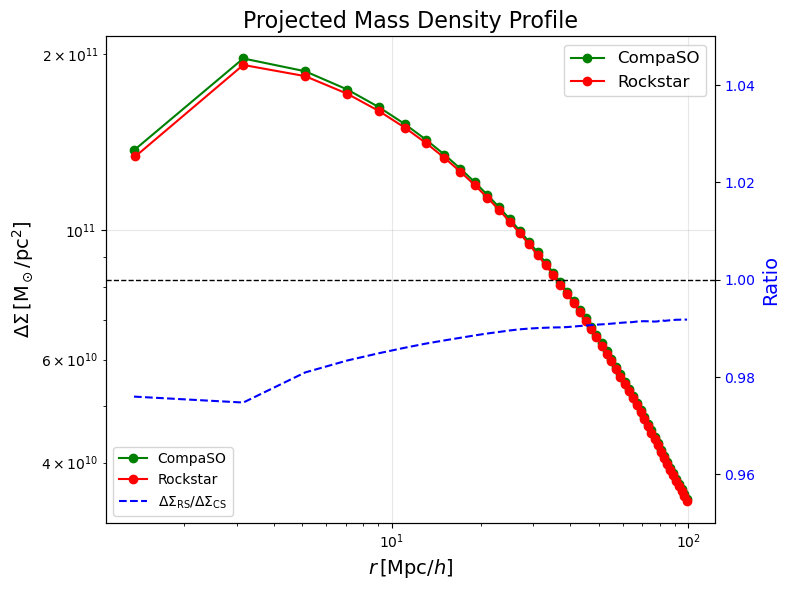

In [93]:
# Densité critique de l'univers
Omega_m = get_variable("/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100//halos/z0.500/header", name='Omega_M')
rho_crit = 2.775e11 * Omega_m  # Densité moyenne de la matière en M_sun/Mpc^3

# Fonction d'intégration
def delta_sigma_integrand(r_prime, r, xi_gm_interp):
    return xi_gm_interp(r_prime) * (r_prime / r)

xi_gm_interp_cs = interp1d(r_gm_cs, xi_gm_cs, kind='linear', bounds_error=False, fill_value="extrapolate")
xi_gm_interp_rs = interp1d(r_gm_rs, xi_gm_rs, kind='linear', bounds_error=False, fill_value="extrapolate")

# Calcul de Delta Sigma pour chaque r
delta_sigma_cs = []
delta_sigma_rs = []

for r in r_gm_cs:
    integral, _ = quad(delta_sigma_integrand, 1e-4, r, args=(r, xi_gm_interp_cs), limit=200, epsabs=1e-4, epsrel=1e-3)
    delta_sigma_cs.append(rho_crit * integral) 

for r in r_gm_rs:
    integral, _ = quad(delta_sigma_integrand, 1e-4, r, args=(r, xi_gm_interp_rs), limit=200, epsabs=1e-4, epsrel=1e-3)
    delta_sigma_rs.append(rho_crit * integral) 

# Convertir en tableau numpy
delta_sigma_cs= np.array(delta_sigma_cs)
delta_sigma_rs= np.array(delta_sigma_rs)

# # Tracé du profil de densité de masse
# plt.figure(figsize=(8, 6))
# plt.loglog(r_gm_cs, delta_sigma_cs, marker='o', label=r'CompaSO', color='green')
# plt.loglog(r_gm_rs, delta_sigma_rs, marker='o', label=r'Rockstar', color='red')
# plt.xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
# plt.ylabel(r"$\Delta \Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
# plt.title("Projected Mass Density Profile", fontsize=16)
# plt.grid(True, alpha=0.3)
# plt.legend(fontsize=12)
# plt.show()

plt.figure(figsize=(8, 6))

# Axe principal : Delta Sigma
fig, ax = plt.subplots(figsize=(8, 6))

ax.loglog(r_gm_cs, delta_sigma_cs, marker='o', label=r'CompaSO', color='green')
ax.loglog(r_gm_rs, delta_sigma_rs, marker='o', label=r'Rockstar', color='red')

ax.set_xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
ax.set_ylabel(r"$\Delta \Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
ax.set_title("Projected Mass Density Profile", fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='upper right')

# Axe secondaire pour le ratio
ax2 = ax.twinx()
ratio = delta_sigma_rs / delta_sigma_cs
ax2.plot(r_gm_cs, ratio, linestyle='--', color='blue', label=r'$\Delta\Sigma_{\rm RS} / \Delta\Sigma_{\rm CS}$')

ax2.set_ylabel("Ratio", fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axhline(1, linestyle='--', color='black', linewidth=1)
ax2.set_ylim(0.95,1.05)

# Légende combinée
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fontsize=10, loc='lower left')

plt.tight_layout()
plt.show()

In [94]:
Delta_Sigma_cs, SIGMA_MEAN_cs, SIGMA_cs = compute_HOD_lensing(r_gm_cs, xi_gm_cs, rho_crit)

Delta_Sigma_rs, SIGMA_MEAN_rs, SIGMA_rs = compute_HOD_lensing(r_gm_rs, xi_gm_rs, rho_crit)

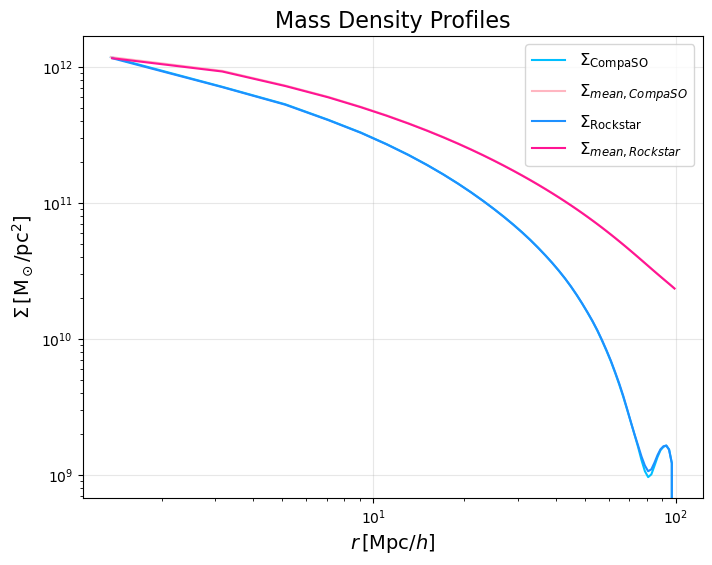

In [95]:
plt.figure(figsize=(8, 6))
plt.loglog(r_gm_cs, SIGMA_cs, label=r'$\Sigma_{\text{CompaSO}}$', color='deepskyblue')
plt.loglog(r_gm_cs, SIGMA_MEAN_cs, label=r'$\Sigma_{mean, CompaSO}$', color='lightpink')
plt.loglog(r_gm_rs, SIGMA_rs, label=r'$\Sigma_{\text{Rockstar}}$', color='dodgerblue')
plt.loglog(r_gm_rs, SIGMA_MEAN_rs, label=r'$\Sigma_{mean, Rockstar}$', color='deeppink')
plt.xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
plt.ylabel(r"$\Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
plt.title("Mass Density Profiles", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

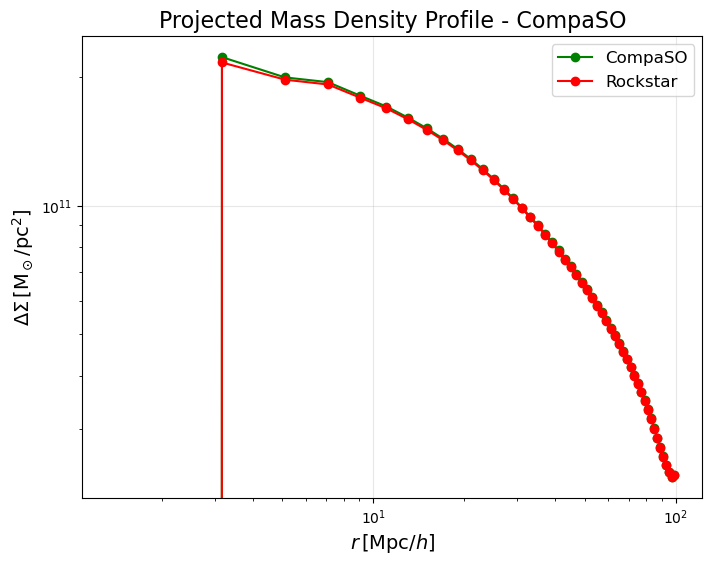

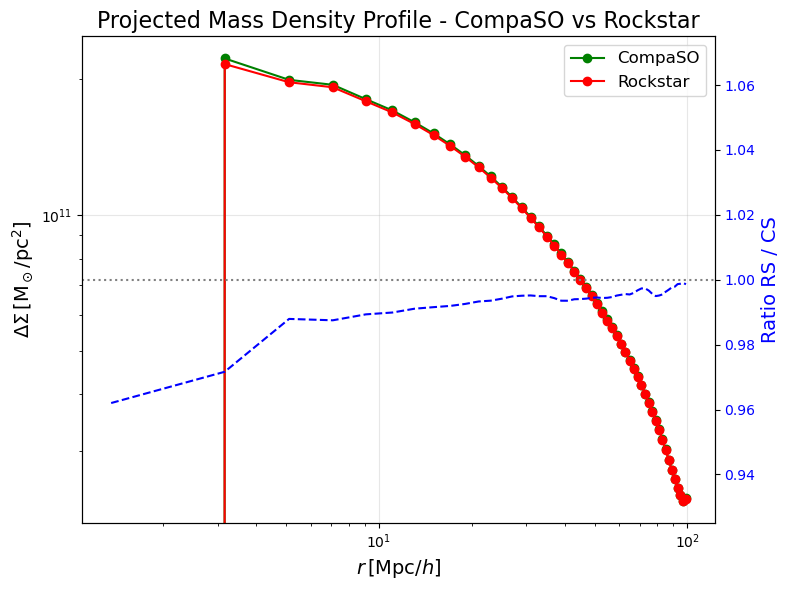

In [99]:
plt.figure(figsize=(8, 6))
plt.loglog(r_gm_cs, Delta_Sigma_cs, marker='o', label=r'CompaSO', color='green')
plt.loglog(r_gm_rs, Delta_Sigma_rs, marker='o', label=r'Rockstar', color='red')
plt.xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
plt.ylabel(r"$\Delta \Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
plt.title("Projected Mass Density Profile - CompaSO", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 6))

# Premier axe : Delta Sigma
ax1.loglog(r_gm_cs, Delta_Sigma_cs, marker='o', label='CompaSO', color='green')
ax1.loglog(r_gm_rs, Delta_Sigma_rs, marker='o', label='Rockstar', color='red')
ax1.set_xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
ax1.set_ylabel(r"$\Delta \Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=12)

# Axe secondaire pour le ratio
ax2 = ax1.twinx()

# Assure-toi que r_gm_rs == r_gm_cs ou interpoler sinon
ratio = Delta_Sigma_rs / Delta_Sigma_cs
ax2.plot(r_gm_cs, ratio, color='blue', linestyle='--', label='Ratio RS/CS')

# Style de l'axe ratio
ax2.set_ylabel('Ratio RS / CS', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axhline(1, linestyle=':', color='gray')

# Limites optionnelles du ratio
ax2.set_ylim(0.925, 1.075)  # ou adapte dynamiquement

plt.title("Projected Mass Density Profile - CompaSO vs Rockstar", fontsize=16)
fig.tight_layout()
plt.show()

# Kd Tree

In [ ]:
def match_halos(positions_A, positions_B, max_distance=1.0):

    # Compute a KDTree on the B catalog
    tree = KDTree(positions_B)

    # Find the nearest neighbour of halos A in B  
    distances, indices_B = tree.query(positions_A)

    # Filter pairs where the distance is reasonable
    mask = distances < max_distance
    indices_A = np.arange(len(positions_A))[mask]  # Halos A with a match
    indices_B = indices_B[mask]  # corresponding halos B

    return indices_A, indices_B, distances[mask]

In [ ]:
# Associate the halos
indices_cs, indices_rs, distances = match_halos(positions_cs, sampled_positions_rs, max_distance=1.0)

# Statistical data for the differences of centers of mass 
delta_r = distances 
mean_offset = np.mean(delta_r)
std_offset = np.std(delta_r)

print(f"Moyenne du décalage des centres de masse: {mean_offset:.3f} Mpc/h")
print(f"Écart-type du décalage des centres de masse: {std_offset:.3f} Mpc/h")

In [ ]:
# Histogram of the center of mass differences
plt.figure(figsize=(8, 6))
plt.hist(delta_r, bins=100, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel(r'$\Delta r$ [Mpc/h]', fontsize=14)
plt.ylabel('Nombre de halos', fontsize=14)
plt.title('Distribution des différences des centres de masse', fontsize=16)
plt.grid(True, alpha=0.3)

plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Halos positions in CompaSo (blue points)
ax.scatter(positions_cs[indices_cs, 0], positions_cs[indices_cs, 1], positions_cs[indices_cs, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)

# Corresponding positions in Rockstar (red points)
ax.scatter(sampled_positions_rs[indices_rs, 0], sampled_positions_rs[indices_rs, 1], sampled_positions_rs[indices_rs, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)
ax.set_ylim((0,50))
ax.set_xlim((0,50))
ax.set_zlim((0,50))
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Comparaison des positions des halos')
ax.legend()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x_min, x_max = 0, 50
y_min, y_max = 0, 50
z_min, z_max = 0, 50

# Masks
mask_cs = (
    (positions_cs[:, 0] >= x_min) & (positions_cs[:, 0] <= x_max) &
    (positions_cs[:, 1] >= y_min) & (positions_cs[:, 1] <= y_max) &
    (positions_cs[:, 2] >= z_min) & (positions_cs[:, 2] <= z_max)
)

mask_rs = (
    (sampled_positions_rs[:, 0] >= x_min) & (sampled_positions_rs[:, 0] <= x_max) &
    (sampled_positions_rs[:, 1] >= y_min) & (sampled_positions_rs[:, 1] <= y_max) &
    (sampled_positions_rs[:, 2] >= z_min) & (sampled_positions_rs[:, 2] <= z_max)
)

# Apply masks
positions_cs_filtered = positions_cs[mask_cs]
sampled_positions_rs_filtered = sampled_positions_rs[mask_rs]

# Plot
ax.scatter(positions_cs_filtered[:, 0], positions_cs_filtered[:, 1], positions_cs_filtered[:, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)

ax.scatter(sampled_positions_rs_filtered[:, 0], sampled_positions_rs_filtered[:, 1], sampled_positions_rs_filtered[:, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))

ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Comparaison des positions des halos')
ax.legend()

plt.show()

In [ ]:
from scipy.spatial import cKDTree

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Define terminals
x_min, x_max = 0, 50
y_min, y_max = 0, 50
z_min, z_max = 0, 50

# Masks 
mask_cs = (
    (positions_cs[:, 0] >= x_min) & (positions_cs[:, 0] <= x_max) &
    (positions_cs[:, 1] >= y_min) & (positions_cs[:, 1] <= y_max) &
    (positions_cs[:, 2] >= z_min) & (positions_cs[:, 2] <= z_max)
)

mask_rs = (
    (sampled_positions_rs[:, 0] >= x_min) & (sampled_positions_rs[:, 0] <= x_max) &
    (sampled_positions_rs[:, 1] >= y_min) & (sampled_positions_rs[:, 1] <= y_max) &
    (sampled_positions_rs[:, 2] >= z_min) & (sampled_positions_rs[:, 2] <= z_max)
)

# Apply masks
positions_cs_filtered = positions_cs[mask_cs]
positions_rs_filtered = sampled_positions_rs[mask_rs]

# Building the KDTree for Rockstar
tree_rs = cKDTree(positions_rs_filtered)

# Find the nearest neighbour of each CompaSo halo in Rockstar
distances, indices_rs = tree_rs.query(positions_cs_filtered)

# Plot
ax.scatter(positions_cs_filtered[:, 0], positions_cs_filtered[:, 1], positions_cs_filtered[:, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)

ax.scatter(positions_rs_filtered[:, 0], positions_rs_filtered[:, 1], positions_rs_filtered[:, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)

# Draw the lines linking the associated halos
for i, j in enumerate(indices_rs):
    x = [positions_cs_filtered[i, 0], positions_rs_filtered[j, 0]]
    y = [positions_cs_filtered[i, 1], positions_rs_filtered[j, 1]]
    z = [positions_cs_filtered[i, 2], positions_rs_filtered[j, 2]]
    ax.plot(x, y, z, color="black", alpha=0.6, linewidth=1)  # Tracer une ligne entre les deux points

# Définir les limites d'affichage
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))

# Labels et titre
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Comparaison des positions des halos avec appariement KDTree')
ax.legend()

plt.show()

In [ ]:
plt.hist(distances, bins=100, alpha=0.7, color='blue')
plt.xlabel("Matching distance [Mpc/h]")
plt.ylabel("Number of pairs")
plt.title("Distribution of distances between associated halos")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Compute KDTrees for both catalogues
tree_rs = cKDTree(positions_rs_filtered)
tree_cs = cKDTree(positions_cs_filtered)

# Find the nearest neighbour of each halo of CompaSo in Rockstar
distances_cs_to_rs, indices_rs = tree_rs.query(positions_cs_filtered)

# Find the nearest neighbour of each halo of Rockstar in CompaSo
distances_rs_to_cs, indices_cs = tree_cs.query(positions_rs_filtered)

# Filter the pairs that are mutually nearest neighbours
mutual_matches = []
matched_distances = []
for i, j in enumerate(indices_rs):
    if indices_cs[j] == i:  # Check the reciprocity of nearest neighbour
        mutual_matches.append((i, j))
        matched_distances.append(distances_cs_to_rs[i])

matched_distances = np.array(matched_distances)

# Filtered halos
ax.scatter(positions_cs_filtered[:, 0], positions_cs_filtered[:, 1], positions_cs_filtered[:, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)
ax.scatter(positions_rs_filtered[:, 0], positions_rs_filtered[:, 1], positions_rs_filtered[:, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)

# Draw lines connecting only mutual pairs
for i, j in mutual_matches:
    x = [positions_cs_filtered[i, 0], positions_rs_filtered[j, 0]]
    y = [positions_cs_filtered[i, 1], positions_rs_filtered[j, 1]]
    z = [positions_cs_filtered[i, 2], positions_rs_filtered[j, 2]]
    ax.plot(x, y, z, color="black", alpha=0.6, linewidth=1)  

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))

ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Mutual Nearest Neighbor')
ax.legend()

plt.show()

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(matched_distances, bins=100, color='blue', alpha=0.7)
plt.xlabel("Distance between paired halos [Mpc/h]", fontsize=14)
plt.ylabel("Number of pairs", fontsize=14)
plt.title("Distribution of distances between mutually paired halos", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
matched_cs = positions_cs_filtered[indices_cs]  
matched_rs = positions_rs_filtered[indices_rs]

print(matched_cs.T.shape)

In [ ]:
results_xi_gm_matched = TwoPointCorrelationFunction(
    mode='smu',
    edges=(bins_s, bins_mu),
    data_positions1=positions_mm_sampled,  
    data_positions2=matched_cs.T, 
    boxsize=boxsize_cs,
    nthreads=32,
    los='z'
)

r_matched, xi_gm_matched = results_xi_gm_matched(ells=(0,), return_sep=True)

In [ ]:
print_multipoles(results_xi_gm_matched, ells, title = 'GM')

In [ ]:
s_gm, xiell_gm = results_gm_cs(ells=ells, return_sep=True)
s_gm_matched, xiells_gm_matched = results_xi_gm_matched(ells=ells, return_sep=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Plot the difference between multipoles in each case
for i, ell in enumerate(ells):
    ax = axes[i]

    # Compute the difference
    delta_xi = (s_gm**2 * xiell_gm[i]) - (s_gm_matched**2 * xiells_gm_matched[i])

    # plot
    ax.plot(s_gm, delta_xi, label=rf'$\ell = {ell}$', color='black', linestyle='-')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel(r'$s \, [\mathrm{Mpc}/h]$', fontsize=12)
    ax.set_title(rf'Différence $\xi_{{\ell}}$ ($\ell={ell}$)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[0].set_ylabel(r'$\Delta \xi_{\ell}(s)$', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
n_samples = 3
percent = 0.1  # 10% des halos

# tocker les résultats pour chaque échantillon
xi_gm_samples = []

for i in range(n_samples):
    print(f"🔄 Échantillon {i+1}/{n_samples}")

    ## CompaSo
    sampled_indices_cs_gm = sample_take(id=hcat_filtered['id'], mass=Mhalos_filtered_CS, percent=percent)
    sampled_halos_cs_gm = hcat_filtered[sampled_indices_cs_gm]
    sampled_positions_cs_gm = np.array(sampled_halos_cs_gm['x_L2com'])
    sampled_positions_cs_gm = sampled_positions_cs_gm.astype(np.float64)

    ## Rockstar
    sampled_indices_rs_gm = sample_take(id=ids_filtered_RS, mass=Mhalos_filtered_RS, percent=percent)
    sampled_positions_rs_gm = positions_RS[sampled_indices_rs_gm]

    # KDTree to match halos
    tree_rs = cKDTree(sampled_positions_rs_gm)
    distances, indices_rs_gm = tree_rs.query(sampled_positions_cs_gm)
 
    matched_rs = sampled_positions_rs_gm[indices_rs_gm]
    
    results_gm_cs = TwoPointCorrelationFunction(
    mode='smu',
    edges=(bins_s, bins_mu),
    data_positions1=positions_mm_sampled,  
    data_positions2=matched_rs.T, 
    boxsize=boxsize_rs,
    nthreads=32,
    los='z'
    )   

    # Compute xi_{gm} for the sample
    s_gm, xiell_gm_sample = results_gm_cs(ells=ells, return_sep=True) 

    xi_gm_samples.append(xiell_gm_sample)

# Numpy table
xi_gm_samples = np.array(xi_gm_samples)  # Shape : (n_samples, n_ells, n_r) (10, 3, 50)

xi_gm_mean = np.mean(xi_gm_samples, axis=0)
xi_gm_std = np.std(xi_gm_samples, axis=0)

# Correlation function plot with uncertainties
fig, axes = plt.subplots(nrows=1, ncols=len(ells), figsize=(15, 5), sharex=True, sharey=True)

for i, ell in enumerate(ells):
    ax = axes[i]
    ax.plot(s_gm, s_gm**2 * xi_gm_mean[i], label=rf'mean', color='blue')
    ax.plot(s_gm, s_gm**2 * xi_gm_std[i], label=rf'std', color='black')
    ax.fill_between(s_gm, s_gm**2 * (xi_gm_mean[i] - xi_gm_std[i]), s_gm**2 * (xi_gm_mean[i] + xi_gm_std[i]),
                    color='blue', alpha=0.2, label="Bootstrap error")
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel(r'$s \, [\mathrm{Mpc}/h]$', fontsize=12)
    ax.set_title(rf'$s^{2}\xi_{ell}$', fontsize=14)
    ax.grid(True, alpha=0.3)  
    ax.legend() 

axes[0].set_ylabel(r'$s^{2} \xi_{\ell}(s)$', fontsize=14)  
plt.tight_layout()
plt.show()

In [ ]:
# Correlation function plot with uncertainties
fig, axes = plt.subplots(nrows=1, ncols=len(ells), figsize=(15, 5), sharex=True, sharey=True)

for i, ell in enumerate(ells):
    ax = axes[i]
    ax.plot(s_gm, s_gm**2 * xi_gm_mean[i], label=rf'mean', color='blue')
    ax.plot(s_gm, s_gm**2 * xi_gm_std[i], label=rf'std', color='black')
    ax.fill_between(s_gm, s_gm**2 * (xi_gm_mean[i] - xi_gm_std[i]), s_gm**2 * (xi_gm_mean[i] + xi_gm_std[i]),
                    color='blue', alpha=0.2, label="Bootstrap error") 
     
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel(r'$s \, [\mathrm{Mpc}/h]$', fontsize=12) 
    ax.grid(True, alpha=0.3) 
    ax.legend()   

axes[0].set_ylabel(r'$s^{2} \xi_{\ell}(s)$', fontsize=14)  
axes[1].set_title('2PCF with uncertainties', fontsize=14)
plt.tight_layout() 
plt.show()

In [ ]:
print(xi_gm_mean) 
print(xi_gm_std) 